In [ ]:
""" major improvements, so moving here to allow cleaner code.
see devo_taskmodel_071121.ipynb

NOTE (9/15/21) - Use this over the devo taskmodel 0711. 
Although have not fully confirmed this is getting everythign
"""


In [1]:
from pythonlib.behmodel.score_dataset import score_dataset
# from pythonlib.behmodel.scorer.prior_functions import prior_feature_extractor
from pythonlib.behmodel.scorer.likeli_functions import likeli_dataset
from pythonlib.behmodel.scorer.poster_functions import poster_dataset
from pythonlib.behmodel.behmodel import BehModel
from pythonlib.behmodel.scorer.scorer import Scorer
from pythonlib.dataset.dataset import Dataset
from pythonlib.dataset.analy_dlist import concatDatasets
from pythonlib.dataset.analy import preprocessDat
import numpy as np
import matplotlib.pyplot as plt
from pythonlib.dataset.beh_model_comparison import plots_cross_prior_and_model_combined, ColNames
from pythonlib.behmodel.behmodel_handler import cross_dataset_model_wrapper_params
from pythonlib.behmodel.behmodel_handler import cross_dataset_model_wrapper, bmh_optimize_single, bmh_results_to_dataset, cross_dataset_model_wrapper_params, bmh_save, bmh_load
from pythonlib.dataset.analy import extract_strokes_monkey_vs_self


##### 1) Always load here

In [ ]:
# Load datasets
SDIR = "/data2/analyses/main/model_comp/planner"

SUBSAMPLE = False

# animal = "Red"
# expt = "lines5"
# rule_list = ["bent"]

animal = "Pancho"
expt = "gridlinecircle"
# rule_list = ["baseline", "linetocircle", "circletoline", "lolli"]
rule_list = ["linetocircle", "circletoline", "lolli"]

LOAD_ALL_PARSES = False
ONLY_SUMMARY_DATES = False
EXTRACT_BEH_ALIGNED_PARSES = False
FIXED = True

In [ ]:
# LOAD ALL DATASETS
Dlist  = []
for rule in rule_list:
    D = Dataset([])
    D.load_dataset_helper(animal, expt, rule=rule)
    
    if SUBSAMPLE:
        if FIXED:
            D.subsampleTrials(1,2)
        else:
            D.subsampleTrials(10, 2)
        
    D.load_tasks_helper()
    
    if FIXED:
        D.filterPandas({"random_task":[False], "insummarydates":[ONLY_SUMMARY_DATES]}, "modify")
    else:
        D.filterPandas({"insummarydates":[ONLY_SUMMARY_DATES]}, "modify")
    
    if expt in ["lines5"]:
        pathbase = None
        name_ver = "trialcode"
        if LOAD_ALL_PARSES:
            list_parse_params = [
                {"quick":True, "ver":"graphmod", "savenote":f"fixed_{FIXED}"},
                {"quick":True, "ver":"nographmod", "savenote":f"fixed_{FIXED}"}]
            list_suffixes = ["graphmod", "nographmod"] # the name in dataset
        else:
            list_parse_params = [
                {"quick":True, "ver":"graphmod", "savenote":f"fixed_{FIXED}"}]
            list_suffixes = ["graphmod"]
    elif expt in ["gridlinecircle"]:
        pathbase = f"/data2/analyses/database/PARSES_GENERAL/{expt}"
        name_ver = "unique_task_name"
        if LOAD_ALL_PARSES:
            list_parse_params = [
                {"quick":True, "ver":"graphmod", "savenote":""},
                {"quick":True, "ver":"nographmod", "savenote":""}]
            list_suffixes = ["graphmod", "nographmod"] # the name in dataset
        else:
            list_parse_params = [
                {"quick":True, "ver":"graphmod", "savenote":""}]
            list_suffixes = ["graphmod"]
    else:
        assert False
    
        
    D.parser_load_presaved_parses(list_parse_params, list_suffixes, pathbase=pathbase, name_ver=name_ver,
                                 ensure_extracted_beh_aligned_parses=EXTRACT_BEH_ALIGNED_PARSES)
    Dlist.append(D)
        
# Preprocess
D, GROUPING, GROUPING_LEVELS, FEATURE_NAMES, SCORE_COL_NAMES = preprocessDat(Dlist[0], expt)

##### Debug - for each parser only keep the parses that are perms of baseparses
Because of memory crashing

In [ ]:
assert np.all(np.diff([p["index"] for p in P.Parses])==1.), "not sure if index will match ind"

In [ ]:
# Make sure grouping levels is not adding things that dont exist in rule list
if expt in ["gridlinecircle"]:
    GROUPING_LEVELS = rule_list
else:
    print(GROUPING_LEVELS, rule_list)
    assert False, "are these the same? shuld be"
print(GROUPING_LEVELS, rule_list)


##### Subsample D to only keep subset of tasks.

In [262]:
from pythonlib.dataset.analy_dlist import subsampleTrialsByFixedTask
Dlist = subsampleTrialsByFixedTask(Dlist, 2)

mixture2-ss-1_1-573946
mixture2-ss-1_1-899756
mixture2-ss-2_1-092894
mixture2-ss-2_1-111763
mixture2-ss-2_1-121199
mixture2-ss-2_1-542064
mixture2-ss-2_1-597648
mixture2-ss-2_1-795134
mixture2-ss-2_1-824096
mixture2-ss-2_1-854519
mixture2-ss-3_1-085968
mixture2-ss-3_1-113921
mixture2-ss-3_1-510665
mixture2-ss-3_1-549005
mixture2-ss-3_1-632820
mixture2-ss-3_1-801517
mixture2-ss-3_1-995290
mixture2-ss-4_1-586590
mixture2-ss-4_1-780727
mixture2-ss-5_1-048096
mixture2-ss-5_1-064566
mixture2-ss-5_1-074007
mixture2-ss-5_1-085544
mixture2-ss-5_1-242738
mixture2-ss-5_1-289925
mixture2-ss-5_1-331339
mixture2-ss-5_1-383971
mixture2-ss-5_1-389916
mixture2-ss-5_1-407986
mixture2-ss-5_1-610091
mixture2-ss-5_1-614601
mixture2-ss-5_1-656860
mixture2-ss-5_1-734320
mixture2-ss-5_1-767202
mixture2-ss-5_1-984466
mixture2-ss-6_1-310208
mixture2-ss-6_1-402226
mixture2-ss-6_1-854929
mixture2-ss-6_1-948104
mixture2-ss-6_1-976501


#### Extract best-perms for each parse (v1, no hierarhcy allowed, not chunks)

In [ ]:
for D in Dlist:
    D.parser_load_presaved_parses(list_parse_params, list_suffixes, pathbase=pathbase, name_ver=name_ver,
                                 ensure_extracted_beh_aligned_parses=EXTRACT_BEH_ALIGNED_PARSES)
    D.parser_extract_bestperms_wrapper(saveon=False, force_redo=True)

#### Extract best-perms for each parse (v2.1, using chunks, hierarchies) [debugging]
v2.1 is old version, saving base parses into self.Parse. Discontinued on 9/23/21

In [ ]:
# NOte: method is bery different, enmerates all perms instead of greedy saerch as above

In [ ]:
# DO FOR A SINGLE TRIAL
indtrial = 0
D._parser_extract_chunkparses(indtrial, list_parse_params[0], saveon=False)

##### Check that gotten best-perms for all base parses [debugging]

In [ ]:
# EXTRACT THE SINGLE PARSE THAT BEST MATCHES BEH
D = Dlist[0]
indtrial = 0
parser = "parser_graphmod"
P = D.Dat.iloc[indtrial][parser]
taskname = D.Dat.iloc[indtrial]["unique_task_name"]
trialcode = D.Dat.iloc[indtrial]["trialcode"]
rule = "lolli"

print(taskname)

trial_tuple = D.trial_tuple(indtrial)
print(trial_tuple)

# P.findparses_bycommand("best_perm_of", [0, ('Pancho', 'gridlinecircle', 'linetocircle', '210823-1-587')])
if False:
    P.findparses_bycommand("best_perm_of", [0, (None, None,  None, None)])

    [p["bestperm_of_list"] for p in P.Parses if len(p["bestperm_of_list"])>0]
    [("*", i, p["bestperm_beh_list"], p["bestperm_of_list"]) for i, p in enumerate(P.Parses) if len(p["bestperm_of_list"])>0]

    x = np.zeros((10,))
    x[[8, 9]]=1
    x

a = [("base", 1), 2]
a.index(2)

# Confirm that there are perms for this task and rule
list_perms = P.findparses_bycommand("find_perms_for_a_rule", {"rule":rule})

list_perms

for indparse in list_indparse:
    # find all perms that are of this 
    inds = P.findparses_bycommand("permutation_of_v2", {"parsekind": "base", "ind":indparse}, is_base_parse=False)
    
    # find all perms which are best of this indparse
    ind_best = P.findparses_bycommand("best_perm_of", [("base", indparse), trial_tuple])
    
    print(ind_best)
    
    


indtrial = 18
assert D.Dat.iloc[indtrial]["random_task"] == False
P = D.parser_get_parser_helper(indtrial)
rule = "lolli"
rule = D.rules(force_single=True)[0]
trial_tuple = D.trial_tuple(indtrial)

print(rule, trial_tuple)
P.findparses_bycommand("best_fit_helper", {"trial_tuple":trial_tuple, "rule":rule})


In [ ]:
# RERUN EXTRACTION FOR ALL TRIALS
for indtrial in range(len(D.Dat)):
    D._parser_extract_chunkparses(indtrial, list_parse_params[0], False)

In [ ]:
# Print for this trial all the best fits
P = D.parser_get_parser_helper(indtrial)
for i, p in enumerate((P.Parses)):
    if len(p["bestperm_beh_list"])>0:
        print(i, p["bestperm_beh_list"])

In [ ]:
# Print the best-fit for each combo of rule and trial
list_rules = ["baseline", "linetocircle", "circletoline", "lolli"]

indtrial = 14
PLOT = False
for rule in list_rules:
    for indtrial in range(len(D.Dat)):

        assert D.Dat.iloc[indtrial]["random_task"] == False
        P = D.parser_get_parser_helper(indtrial)
    #         rule = "linetocircle"
        # rule = D.rules(force_single=True)[0]
        trial_tuple = D.trial_tuple(indtrial)

        inds = P.findparses_bycommand("best_fit_helper", {"trial_tuple":trial_tuple, "rule":rule})
        print("---", indtrial, rule, trial_tuple, inds, " ---- ", len(inds))

        # Plot to compare
        if PLOT:
            D.plotSingleTrial(indtrial)
            list_parses_strokes = P.extract_parses_wrapper(inds, "strokes")
            D.plotMultStrokes(list_parses_strokes)


##### Reset perm paress

In [ ]:
if True:
    # adding ParseBase
    for indtrial in range(len(D.Dat)):
        P = D.parser_get_parser_helper(indtrial)
        P.ParsesBase = []
        P.Parses = []
        P._parses_fill_in_missing_keys()

##### [quick] load best-fit for a given rule, and trial
(NOTE: this is old version that didnto use baseparses) [IGNORE]

In [ ]:
D = Dlist[0]
indtrial = 19
parser = "parser_graphmod"
P = D.Dat.iloc[indtrial][parser]
taskname = D.Dat.iloc[indtrial]["unique_task_name"]
print(taskname)
rule = "lolli"
indtrial = # behavior

P.findparses_bycommand("best_perm_of", [0, (None, None,  None, None)])


# Check that inds exist for best perms

D = Dlist[0]
indtrial = 0
parser = "parser_graphmod"
P = D.Dat.iloc[indtrial][parser]

# 1. get inds for base parses
inds_baseparse = P.findparses_bycommand("base_parses")

# for each baseparse, check that there exists best perm
for i in inds_baseparse:
    inds = P.findparses_bycommand("best_perm_of", [i, (None, None, None, None)])
    print(inds)
    
#     x = P.findparses_bycommand("permutation_of", {"of":i})
#     y = P.findparses_bycommand("is_best_perm")
    
#     xy = [yy for yy in y if yy in x]
#     if len(xy)==0:
#         print("no bestperm for indparse: ", i)
#     elif len(xy)>1:
#         print("multiple bestperms for indparse (weird): ", i)
#     else:
#         pass
#         # good.
    

#### v2.2 [9/24/21] Make sure have a best-fit parse for each trial x rule combo
New version, stored in self.BaseParses[ind]["best_fit_perm"]

In [ ]:

D = Dlist[0]
D.Dat["unique_task_name"]

In [ ]:
from pythonlib.dataset.dataset_analy.parses import plot_baseparses_all, plot_and_print_perms_for_each_baseparse, print_summary_bestparses_alltrials, print_summary_all_bestfits_each_baseparse

In [ ]:
print_summary_bestparses_alltrials(D)


In [ ]:
indtrial = 20
plot_baseparses_all(D, indtrial)
plot_and_print_perms_for_each_baseparse(D, indtrial)

print_summary_all_bestfits_each_baseparse(D, indtrial)

##### Redo all chunks extraction steps for a single trial here

In [ ]:
# 1) Reset
if True:
    # adding ParseBase
    for i in range(len(D.Dat)):
        P = D.parser_get_parser_helper(i)
        P.ParsesBase = []
        P.Parses = []
        P._parses_fill_in_missing_keys()

In [ ]:
D.parser_extract_chunkparses(indtrial, None, False, force_redo_best_fit=True)

In [ ]:
inds = P.findparses_bycommand("permutation_of_v2", {"parsekind": "base", "ind":2}, is_base_parse=False)
print(inds)

In [ ]:
inds = P.findparses_bycommand("permutation_of_v2", {"parsekind": "base", "ind":2}, is_base_parse=False)
print(inds)

### Plot all graphs and example parses

In [ ]:
for graphmod in list_suffixes:
    nplot = 20
    parse_params ={"quick":True, "ver":graphmod, "savenote":"fixed_True"}
    SDIR = D._get_parser_sdir(parse_params)
    sdir = f"{SDIR}/raw_figures"
    import os
    os.makedirs(sdir, exist_ok=True)

    for i in range(len(D.Dat)):
        colname = f"parser_{graphmod}"
        P = D.Dat.iloc[i][colname]
        taskname = D.Dat.iloc[i]["unique_task_name"]
        fig = P.plot_graph()
        fig.savefig(f"{sdir}/{i}-{taskname}-{graphmod}.png")

        # Plot random parses
        figp1 = P.plot_parses(nplot)
        figp1.savefig(f"{sdir}/{i}-{taskname}-{graphmod}-parses_random.png")

        # Plot manually entere
        figman = P.plot_parses("manual_and_perms")
        if figman is not None:
            figman.savefig(f"{sdir}/{i}-{taskname}-{graphmod}-parses_manual.png")
        plt.close("all")

## [SKIP] Other stuff

In [ ]:
# V2: prior params are exposed, so can optimize
from pythonlib.behmodel.behmodel_handler import BehModelHandler
from pythonlib.behmodel.behmodel_getter import quick_getter_with_params
from pythonlib.behmodel.behmodel_handler import prepare_optimization_scipy
    
out = []

for Dthis in Dlist:

    list_mod, list_modnames = quick_getter_with_params("lines5")

    # Generate models
    H = BehModelHandler()
    allow_separate_likelis = False
    H.input_data(Dthis, list_mod[:1], list_modnames[:1], allow_separate_likelis=allow_separate_likelis)
    print("* THis dataset: ", H.D.identifier_string())
    print("* This model(s): ", H.ListModelsIDs)

    modelname = list_modnames[0]
    func = prepare_optimization_scipy(H, modelname)

    ### PLOT COST LANDSCAPE
    array_thetas = np.linspace(-100, 100, 8)
    # array_norms = np.linspace(0.1, 2, 5)
#     array_norms = np.linspace(0.1, 2, 4)
    array_norms = np.asarray([1.])

    for th in array_thetas:
        for no in array_norms:
            prms = (th, no)
            cost = func(prms)
            out.append({
                "cost":cost,
                "th":th,
                "norm":no,
                "dset":H.D.identifier_string()                
            })

In [ ]:
# Plot landscape
import seaborn as sns
import pandas as pd
from pythonlib.tools.snstools import rotateLabel
dfthis = pd.DataFrame(out)
# sns.lineplot(data=dfthis, x="th", y="cost", hue="norm")
fig = sns.catplot(data=dfthis, x="th", y="cost", hue="norm", row="dset", aspect=2)
rotateLabel(fig)

In [ ]:
# Why does landscape not change when theta gets large?

# PREPARE A SINGLE DATASET
ind_dat = 1
Dthis = Dlist[ind_dat]

list_mod, list_modnames = quick_getter_with_params("lines5")

# Generate models
H = BehModelHandler()
allow_separate_likelis = False
H.input_data(Dthis, list_mod[:1], list_modnames[:1], allow_separate_likelis=allow_separate_likelis)
print("* THis dataset: ", H.D.identifier_string())
print("* This model(s): ", H.ListModelsIDs)

modelname = list_modnames[0]
func = prepare_optimization_scipy(H, modelname)

In [ ]:
    
# hand enter specific params
params = (10., 5)
func(params)

### [start here] FITTING/TESTING MODELS

In [ ]:
# gridlinecircle.
# test are in block > N and not random
assert False, "this has been moved - check that it is done"
for D in Dlist:
    if expt in ["gridlinecircle"]:
        print("MOVE THIS TO PREPROCESS.PY")
        key = "random_task"
        list_train = [True]
        list_test = [False]
        D.analy_reassign_monkeytraintest(key, list_train, list_test)
    else:
        assert False

In [ ]:
### SPLIT DATASET
DictD = {}

for D, rule in zip(Dlist, rule_list):

    inds_train, inds_val, inds_test = D.splitTrainTestMonkey(expt, epoch=rule)
    
    DictD[(rule, "train")] = D.subsetDataset(inds_train)
    DictD[(rule, "test")] = D.subsetDataset(inds_test)

    print("**", (rule, "train"), "this many:", len(inds_train))
    print("**", (rule, "test"), "this many:", len(inds_test))


In [ ]:
from pythonlib.behmodel.behmodel_handler import cross_dataset_model_wrapper, bmh_optimize_single, bmh_results_to_dataset, cross_dataset_model_wrapper_params, bmh_save, bmh_load
import os

from pythonlib.tools.expttools import makeTimeStamp, writeDictToYaml
dset = f"{animal}-{expt}"
ts = makeTimeStamp()
SDIR = f"/data2/analyses/main/model_comp/planner/pilot-{ts}/{dset}"
os.makedirs(SDIR, exist_ok=True)
print(SDIR)


## [Start here - trainnig] lines5 and mkvsmk - FIT TO TRAIN

In [ ]:
from pythonlib.dataset.analy_dlist import extract_strokes_monkey_vs_self

In [ ]:
# Prepare strokes (other monkey) in dataset
remove_bad_trial = False
extract_strokes_monkey_vs_self(Dlist, GROUPING, GROUPING_LEVELS, remove_bad_trial=remove_bad_trial)


##### Try out models, debugging etc [See below for full automation of traing]

##### 1a) Load untrained models and apply to dataset (useful for debuging code, etc) [IGNORE THIS]

In [ ]:
for model_class in list_model_class:
    for D, rule in zip(Dlist, rule_list):
        # Get Dataset
        Dlist_this = [DictD[(rule, "train")]]
        GROUPING_LEVELS_this = [rule]
        if False:            
            ListBMH, list_dsets, ListH= cross_dataset_model_wrapper_params(Dlist_this, 
                                                                           model_class, GROUPING_LEVELS_this)
        else:
            MBH = MultBehModelHandler()
            MBH.load_untrained_models(Dlist_this, model_class, GROUPING_LEVELS_this)
            assert False, "incorporate the below into MBH (e..g, a trainmodel module)"


In [ ]:
# Get Dataset
from pythonlib.behmodel.multiple_behmodel_handler import MultBehModelHandler

TRAIN_TEST = "test" # noramlly train on train, but use "test" if want, for debugging.
# model_class = "mix_features_bdn"
# model_class = "mix_features_bdn"
list_model_class = ["chunks"]

assert len(Dlist_this[0].Dat)>0
assert len(Dlist)==len(rule_list)
MBH = MultBehModelHandler()
for model_class in list_model_class:
    for D, rule in zip(Dlist, rule_list):
        
        # Get Dataset
        # (Always use a single dataset. LIkelis shared across models.)
        Dlist_this = [DictD[(rule, TRAIN_TEST)]]
        print("****", Dlist_this)
        print("****", Dlist_this[0].rules())
        GROUPING_LEVELS_this = [rule]
            
        MBH.load_untrained_models(Dlist_this, model_class, GROUPING_LEVELS_this)


In [ ]:
MBH.print_summary_untrained_models()

In [ ]:
# TO TRAIN
if False:
    # If want to train model, run below
    # IDEALLY integrate this into MBH
    bmh_optimize_single(ListBMH, D.identifier_string(),  rule)

    # Optimize
    if model_class=="mkvsmk":
        for H in ListH:
            H.compute_store_priorprobs_vectorized()
            H.compute_store_likelis()
            H.compute_store_likelis_logprobs()
            H.compute_store_posteriors()
    #         if model_class=="lines5":
    else:
        bmh_optimize_single(ListBMH, D.identifier_string(),  rule)

    ### Save
    bmh_save(SDIR, Dlist_this, model_class, GROUPING_LEVELS_this, ListH, TRAIN_TEST)

    bmh_results_to_dataset(ListBMH, suffix=model_class)

In [ ]:
# Summarize 

###### 1a - i) Plots for untrained model. but hand input params, etc, just to debug

In [ ]:
# Compute scores, etc.
MBH.compute_scores_all_old_dataset()

In [ ]:
# TODO:
# way to summarize when theres 4 models.
H = list(MBH.DictTrainedH.values())[1]
H.D.rules()

In [ ]:
for class_mod, H in MBH.DictTrainedH.items():
    print("-- ", class_mod, H)
    H.plot_prior_likeli_sorted(class_mod[1], indtrial, "prior")

In [ ]:
for class_mod, H in MBH.DictTrainedH.items():
    print("-- ", class_mod, H)
    print(H.final_score(class_mod[1]))

In [ ]:
### Plot, for each trial, plot comparison across models
# Condition on single trial, plot all models

indtrial= 0
for class_mod, H in MBH.DictTrainedH.items():
    print("-- ", class_mod, H)
    H.plot_overview_trial(class_mod[1], indtrial)

In [ ]:
# Return scores to dataset
MBH.dataset_assign_all()

In [ ]:
Dthis = Dlist_this[0]
Dthis.Dat

In [ ]:
MBH.dataset_assign_all(use_training=True)

In [ ]:
# See below in this notebook


##### 1b) Load untrained models and dataset and then TRAIN (and save)

In [ ]:
GROUPING_LEVELS = rule_list
TRAIN_TEST = "train"
# model_class = "mkvsmk"
list_model_class = ["mix_features_bdn", "mix_features_bd", "mix_features_bn", "mix_features_dn", 
                    "mix_features_b", "mix_features_d", "mix_features_n", "mkvsmk", "lines5"]
MBH = MultBehModelHandler()
for model_class in list_model_class:
    for D, rule in zip(Dlist, rule_list):
        # Get Dataset
        Dlist_this = [DictD[(rule, "train")]]
        GROUPING_LEVELS_this = [rule]
        if False:            
            ListBMH, list_dsets, ListH= cross_dataset_model_wrapper_params(Dlist_this, 
                                                                           model_class, GROUPING_LEVELS_this)
        else:
            MBH.load_untrained_models(Dlist_this, model_class, GROUPING_LEVELS_this)
            assert False, "incorporate the below into MBH (e..g, a trainmodel module)"


        # Optimize
        if model_class=="mkvsmk":
            for H in ListH:
                H.compute_store_priorprobs_vectorized()
                H.compute_store_likelis()
                H.compute_store_likelis_logprobs()
                H.compute_store_posteriors()
#         if model_class=="lines5":
        else:
            bmh_optimize_single(ListBMH, D.identifier_string(),  rule)
    

        ### Save
        bmh_save(SDIR, Dlist_this, model_class, GROUPING_LEVELS_this, ListH, TRAIN_TEST)

        bmh_results_to_dataset(ListBMH, suffix=model_class)

##### 2) Load saved trained models (including from above), and apply to score any new dataset

In [ ]:
# LOAD
from pythonlib.behmodel.multiple_behmodel_handler import MultBehModelHandler


# SDIR = "/data2/analyses/main/model_comp/planner/pilot-210727_090321/Red-lines5" # (GOOD)
SDIR = "/data2/analyses/main/model_comp/planner/pilot-210727_002853//Red-lines5" # (many models)

# Instead, get classes and rules autoatmically.
# list_mclass = ["mix_features_d", "mix_features_dn", "mix_features_bd", "mix_features_dt"]
# list_mrule = ["straight", "bent"]
MBH = MultBehModelHandler()
MBH.load_pretrained_models(SDIR)

In [ ]:
## PREPARE DATASET
# get test dataset (combine rules)
Dlist_test = []
for rule in rule_list:
    
    Dthis = DictD[(rule, "test")]
    
    # Clear scores, in case they are gotten before...
#     CN = ColNames(["lines5", "mkvsmk"], ["straight", "bent"])
#     cols_to_drop = CN.colnames_score()
#     cols_to_drop = [col for col in cols_to_drop if col in Dtest.Dat.columns]
#     Dthis.Dat = Dthis.Dat.drop(cols_to_drop, axis=1)

    Dlist_test.append(Dthis)

# Prepare strokes (other monkey) in dataset
extract_strokes_monkey_vs_self(Dlist_test, GROUPING, GROUPING_LEVELS)

# # Concat
# Dtest = concatDatasets(Dlist_test)



In [ ]:
# Add positive control model
MBH.load_untrained_models(Dlist, "mkvsmk", ["straight", "bent"])
list_mclass = list(set(list_mclass + ["mkvsmk"]))

MBH.load_untrained_models(Dlist, "random", ["straight", "bent"])
list_mclass = list(set(list_mclass + ["random"]))



In [ ]:
# 2) Apply models to test set
MBH.apply_models_to_mult_new_dataset(Dlist_test)

##### 2b) Load chunks models, which don't need training, and apply to new dataset.

NOTE: See multiple_behmodel_handler_script092621 (That replaces this)

In [267]:
rule_list = ["linetocircle", "circletoline", "lolli"]


# Load other arbitrary models
from pythonlib.behmodel.multiple_behmodel_handler import MultBehModelHandler
MBH = MultBehModelHandler()
rule_list
if True:
    list_rules = rule_list
    for rule in list_rules:
        MBH.load_untrained_models(Dlist, "chunks", [rule])
else:
    MBH.load_untrained_models(Dlist, "chunks", list_rules)

# Summarize models
MBH.print_summary_untrained_models()

# 2) Apply models to test set
MBH.apply_models_to_mult_new_dataset(Dlist)

flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
** dset:  Pancho_gridlinecircle_circletoline model:  linetocircle
flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
** dset:  Pancho_gridlinecircle_lolli model:  linetocircle
flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
** dset:  Pancho_gridlinecircle_linetocircle model:  linetocircle
-- GOT THIS UNTRAINED MODEL:  chunks linetocircle
-- GOT THIS UNTRAINED MODEL:  chunks linetocircle
-- GOT THIS UNTRAINED MODEL:  chunks linetocircle
** OUTCOME:
classes: ['chunks']
rules: {'chunks': ['linetocircle']}
extracted trained models:  {('chunks', 'linetocircle'): <pythonlib.behmodel.behmodel_handler.BehModelHandler object at 0x7efd9e104290>}
flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
** dset:  Pancho_gridlinecircle_circletoline model:  circletoline
flattend parsers and moved to new col:  parses_behmod
Par

[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
behmodel_handler - getting likelis for  circletoline
likeli 0
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
behmodel_handler - getting likelis for  lolli
likeli 0
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores
[likeli_functions] getting scores

In [261]:
## Save extracted likelis, statedict
savedict = {}
for key, DH in MBH.DictTestDH.items():
    D = DH["D"]
    H = DH["H"]
    
    savedict[key] = [D, H.extract_state(get_dataset=False)]
    
import pickle
pathdir = f"{SDIR}/applied_to_test_data"
import os
os.makedirs(pathdir, exist_ok=True)
path = f"{pathdir}/MBH_statedict.pkl"

with open(path, "wb") as f:
    pickle.dump(savedict, f)

print("Saved to:", path)

flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
** dset:  Pancho_gridlinecircle_circletoline model:  linetocircle
flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
** dset:  Pancho_gridlinecircle_lolli model:  linetocircle
flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
** dset:  Pancho_gridlinecircle_linetocircle model:  linetocircle
-- GOT THIS UNTRAINED MODEL:  chunks linetocircle
-- GOT THIS UNTRAINED MODEL:  chunks linetocircle
-- GOT THIS UNTRAINED MODEL:  chunks linetocircle
** OUTCOME:
classes: ['chunks']
rules: {'chunks': ['linetocircle']}
extracted trained models:  {('chunks', 'linetocircle'): <pythonlib.behmodel.behmodel_handler.BehModelHandler object at 0x7efd87ecad10>}
flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
** dset:  Pancho_gridlinecircle_circletoline model:  circletoline
flattend parsers and moved to new col:  parses_behmod
Par

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/lucast4/miniconda3/envs/drag2_matlab/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-261-f4d1aba85a84>", line 19, in <module>
    MBH.apply_models_to_mult_new_dataset(Dlist)
  File "/data1/code/python/pythonlib/pythonlib/behmodel/multiple_behmodel_handler.py", line 217, in apply_models_to_mult_new_dataset
    H.compute_all(mode="test")
  File "/data1/code/python/pythonlib/pythonlib/behmodel/behmodel_handler.py", line 426, in compute_all
    self.compute_store_likelis(force_run=True)
  File "/data1/code/python/pythonlib/pythonlib/behmodel/behmodel_handler.py", line 195, in compute_store_likelis
    self.Likelis[name] = _get_list_likelis(name)
  File "/data1/code/python/pythonlib/pythonlib/behmodel/behmodel_handler.py", line 178, in _get_list_likelis
    likelis = self._score_helper("likeli", modname, i)
  File "/data1/code/py

TypeError: object of type 'NoneType' has no len()

##### 3) Continue (or load at statedict) to analyze/plot scores for test datasets

In [268]:
from pythonlib.behmodel.behmodel_handler import BehModelHandler
from pythonlib.behmodel.multiple_behmodel_handler import MultBehModelHandler
import pickle
    
LOAD = True
expt = "gridlinecircle"
if LOAD:
    
    if expt=="lines5":
        pathdir = "/data2/analyses/main/model_comp/planner/pilot-210727_090321/Red-lines5/applied_to_test_data"
        list_mclass = ["mix_features_bd", "mix_features_bnd", "mix_features_nd", 
                       "mix_features_tbd", "mix_features_tbnd", "mix_features_td", "mix_features_tnd"]
    elif expt=="gridlinecircle":
#         pathdir = "/data2/analyses/main/model_comp/planner/pilot-210927_000520_fulldata/Pancho-gridlinecircle/applied_to_test_data"
        pathdir = "/data2/analyses/main/model_comp/planner/pilot-210927_112632_gridlinecircle_chunks_good/Pancho-gridlinecircle/applied_to_test_data/"
        list_mclass = ["chunks"]
    else:
        assert False
    
    MBH_load = MultBehModelHandler()
    MBH_load.DictTestDH = {}
    
    for dset in ["lolli", "linetocircle", "circletoline"]:
        for mclass in list_mclass:

            # Load this class.
            try:

    #             path = f"{pathdir}/MBH_statedict-{mclass}.pkl"
    #             with open(path, "rb") as f:
    #                 savedict = pickle.load(f)
                path = f"{pathdir}/MBH_statedict-dset_{dset}-mclass_{mclass}.pkl"
                with open(path, "rb") as f:
                    savedict = pickle.load(f)

            except Exception as err:
                path = f"{pathdir}/MBH_statedict.pkl"            
                with open(path, "rb") as f:
                    savedict = pickle.load(f)

            for key, listDH in savedict.items():
                mclass = key[1]
                D = listDH[0]
                Hstate = listDH[1]

                list_mrules = Hstate["modelnames"]
                H = BehModelHandler()
                H.input_data_helper(D, mclass, list_mrules)
                H.apply_state(Hstate)

                MBH_load.DictTestDH[key] = {
                    "D":D,
                    "H":H}
else:
    # Then continue
    MBH_load = MBH

flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
* Setting param, Main lolli to {'norm': (500.0,)}
* Setting param, Main linetocircle to {'norm': (500.0,)}
* Setting param, Main circletoline to {'norm': (500.0,)}
flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
* Setting param, Main lolli to {'norm': (500.0,)}
* Setting param, Main linetocircle to {'norm': (500.0,)}
* Setting param, Main circletoline to {'norm': (500.0,)}
flattend parsers and moved to new col:  parses_behmod
Parsers: ['parser_graphmod']
* Setting param, Main lolli to {'norm': (500.0,)}
* Setting param, Main linetocircle to {'norm': (500.0,)}
* Setting param, Main circletoline to {'norm': (500.0,)}


##### IN PROGRESS [INGORE]
alternarive, loading when there is single for each combo of dset x (mclass, rule) To fix memory issue


In [ ]:
from pythonlib.behmodel.behmodel_handler import BehModelHandler
from pythonlib.behmodel.multiple_behmodel_handler import MultBehModelHandler
import pickle

pathdir = "/data2/analyses/main/model_comp/planner/pilot-210926_195341/Pancho-gridlinecircle/applied_to_test_data"
list_mclass = ["chunks"]
list_rule = ["lolli", "linetocircle", "circletoline"]
MBH_load = MultBehModelHandler()
MBH_load.DictTestDH = {}

for mclass in list_mclass:
    for rule in list_rule:

        # Load this class.
        path = f"{pathdir}/MBH_statedict-mclass_{mclass}-rule_{rule}.pkl"
        with open(path, "rb") as f:
            savedict = pickle.load(f)
        
        for key, listDH in savedict.items():
            mclass = key[1]
            D = listDH[0]
            Hstate = listDH[1]
            
            list_mrules = Hstate["modelnames"]
            
            H = BehModelHandler()
            print(key, D.identifier_string(), mclass, list_mrules)
            
#             H.input_data_helper(D, mclass, list_mrules)
#             H.apply_state(Hstate)

#             MBH_load.DictTestDH[key] = {
#                 "D":D,
#                 "H":H}

##### continuye here (Post-processing, important)

In [271]:
# Extract all datasets
# Checks that any dsets with same dset id are identical
DictD = {}
for key, DH in MBH_load.DictTestDH.items():
    Dthis = DH["D"]
    dsetid = key[0]
    
    # prune off pre-saved scores in D.Dat
    cols_to_drop = [col for col in Dthis.Dat.columns if "behmodpost" in col or "_minus_" in col]
    Dthis.Dat = Dthis.Dat.drop(cols_to_drop, axis=1)

    if dsetid not in DictD.keys():
        DictD[dsetid] = Dthis
    else:
        # confirm that this one matches the old one.
        assert DictD[dsetid].is_equal_to(Dthis)

MBH_load.DictTestD = DictD # save    


# Update MBH with the common dataset
for key, DH in MBH_load.DictTestDH.items():
    dsetid = key[0]
    Dthis = MBH_load.DictTestD[dsetid]
    DH["D"] = Dthis
    DH["H"].D = Dthis
    
print("Resulting datasets:")
print(MBH_load.DictTestD)

for k, v in MBH_load.DictTestD.items():
    print(k, v)

    

Resulting datasets:
{'Pancho_gridlinecircle_lolli': <pythonlib.dataset.dataset.Dataset object at 0x7efd991d6b10>, 'Pancho_gridlinecircle_linetocircle': <pythonlib.dataset.dataset.Dataset object at 0x7efd991d6d90>, 'Pancho_gridlinecircle_circletoline': <pythonlib.dataset.dataset.Dataset object at 0x7efd9929fa50>}
Pancho_gridlinecircle_lolli <pythonlib.dataset.dataset.Dataset object at 0x7efd991d6b10>
Pancho_gridlinecircle_linetocircle <pythonlib.dataset.dataset.Dataset object at 0x7efd991d6d90>
Pancho_gridlinecircle_circletoline <pythonlib.dataset.dataset.Dataset object at 0x7efd9929fa50>


In [ ]:
# [OPTIONAL] LOAD upper bound control 
Dlist = MBH_load.list_D()

# Add control models.
# Add positive control model
if False:
    # old version, worked for lines5
    MBH_load.load_untrained_models(Dlist, "mkvsmk", ["straight", "bent"]) # dlist doesnt matter. this just loads model class
else:
    for rule in list_rules:
        MBH_load.load_untrained_models(Dlist, "mkvsmk", [rule]) # dlist doesnt matter. this just loads model class
        
# list_mclass = list(set(list_mclass + ["mkvsmk"]))

# MBH_load.load_untrained_models(Dlist, "random", ["straight", "bent"])
# list_mclass = list(set(list_mclass + ["random"]))


# apply
# MBH_load.apply_models_to_mult_new_dataset(Dlist, ["mkvsmk", "random"])
MBH_load.apply_models_to_mult_new_dataset(Dlist, ["mkvsmk"])

In [272]:
print("These model classes done applying to test datasets!")
for k, v in MBH_load.DictTestDH:
    print(k, ":", v)

# Repopulate MBH_load.ListMclass
MBH_load._update_test_models()
MBH_load.print_summary()


# Assign things to Dat
MBH_load.dataset_assign_all()


MBH = MBH_load

rule_list = MBH.ColNames.Rules
rule_list

## print summary of extract dataponts
DlistThis = list(MBH_load.DictTestD.values())

for D in DlistThis:
    for col in D.Dat.columns:
        if "behmodpost" in col:
            print(col)
            print(D.Dat[col])
            if any(D.Dat[col].isna().tolist()):
                print(col)
                assert False
        

These model classes done applying to test datasets!
Pancho_gridlinecircle_lolli : chunks
Pancho_gridlinecircle_linetocircle : chunks
Pancho_gridlinecircle_circletoline : chunks
APPLIED TO TEST DATA:
self.ListMclass: ['chunks']
self.DictMrule: {'mkvsmk': ['linetocircle', 'circletoline', 'lolli'], 'chunks': ['circletoline', 'linetocircle', 'lolli']}
scores into Dat: Pancho_gridlinecircle_lolli , col: behmodpost_lolli_chunks
scores into Dat: Pancho_gridlinecircle_lolli , col: behmodpost_linetocircle_chunks
scores into Dat: Pancho_gridlinecircle_lolli , col: behmodpost_circletoline_chunks
scores into Dat: Pancho_gridlinecircle_linetocircle , col: behmodpost_lolli_chunks
scores into Dat: Pancho_gridlinecircle_linetocircle , col: behmodpost_linetocircle_chunks
scores into Dat: Pancho_gridlinecircle_linetocircle , col: behmodpost_circletoline_chunks
scores into Dat: Pancho_gridlinecircle_circletoline , col: behmodpost_lolli_chunks
scores into Dat: Pancho_gridlinecircle_circletoline , col: beh

##### Additional processing/pruning of final datasets
Final = score extracted

In [662]:
# NOTHING SO FAR


#### PLOT - COMBINE DATASETS


In [574]:
SDIR_FIGS = "/data2/analyses/main/model_comp/planner/pilot-210927_112632_gridlinecircle_chunks_good/Pancho-gridlinecircle/applied_to_test_data/FIGS"
import os
os.makedirs(SDIR_FIGS, exist_ok=True)

##### 0) Cross dataset and model, arbitrary number of classes and models

In [275]:
MBH.analy_compute_alignment_wrapper()

DONE Pancho_gridlinecircle_lolli chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_lolli chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_diff_chunks


DONE Pancho_gridlinecircle_lolli chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_lolli chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_diff_chunks
Done!, new len of dataset 518
Monkey priors (datasets):  ['circletoline', 'linetocircle', 'lolli']
Model scores (colnames):  ['behmodpost_circletoline_chunks', 'behmodpost_linetocircle_chunks', 'behmodpost_lolli_chunks']
{'behmodpost_lolli_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_linetocircle_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_circletoline_chunks': [<function <lambda> at 0x7efe3b0d1440>]}
{'behmodpost_lolli_chunks': ['mean'], 'behmodpost_linetocircle_chunks': ['mean'], 'behmodpost_circletoline_chunks': ['mean']}
{'score': ['mean']}


/home/lucast4/miniconda3/envs/drag2_matlab/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 72.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/lucast4/miniconda3/envs/drag2_matlab/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 77.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/lucast4/miniconda3/envs/drag2_matlab/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 74.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


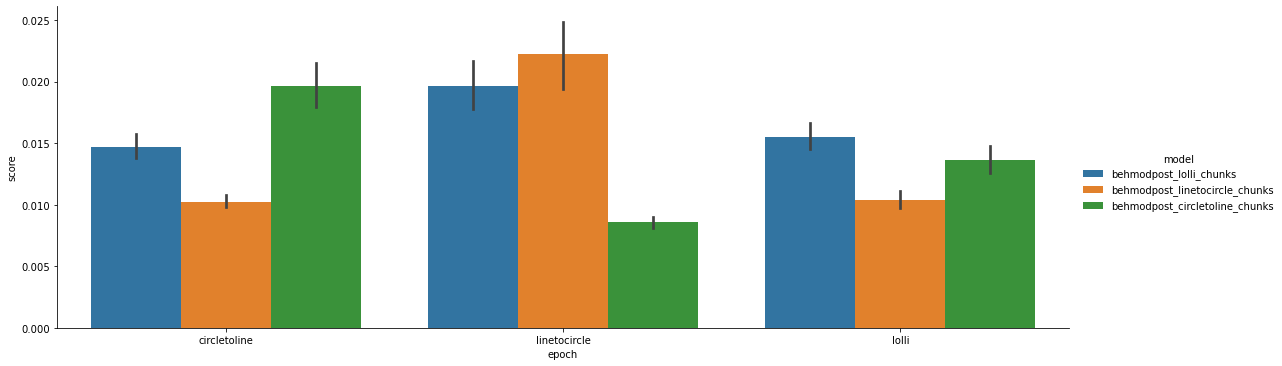

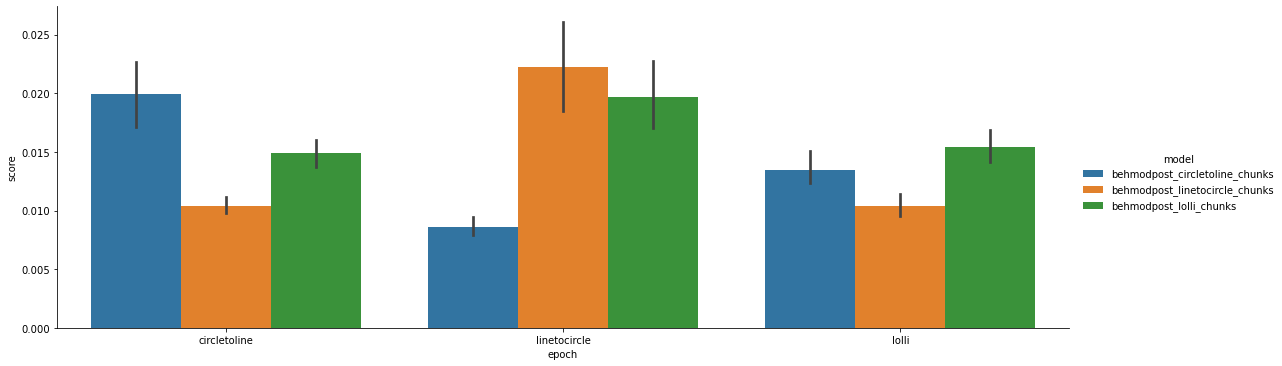

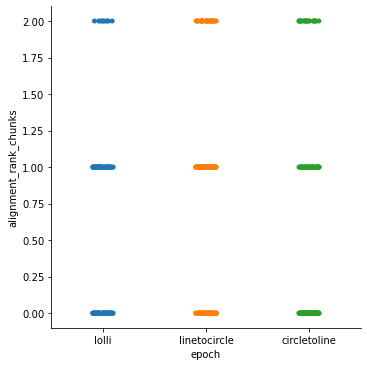

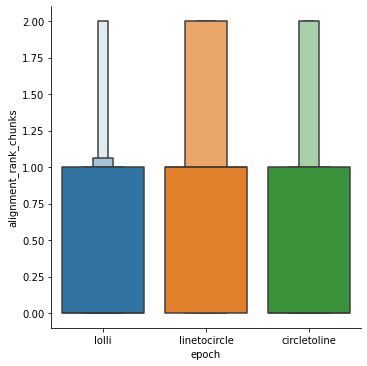

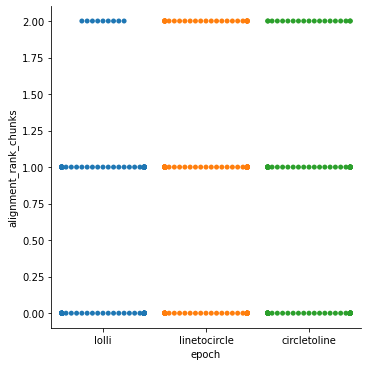

In [296]:
from pythonlib.dataset.beh_model_comparison import plots_cross_prior_and_model_anynum

DatWide, DatFlat, DatThisAgg, DatFlatAgg = plots_cross_prior_and_model_anynum(MBH)

In [531]:
D, DatWide, DatFlat, DatThisAgg, DatFlatAgg, DatFlatAlignment, DatFlatAlignmentAgg = MBH.extract_concatenated_aggregated_dataset()

Done!, new len of dataset 518
Monkey priors (datasets):  ['circletoline', 'linetocircle', 'lolli']
Model scores (colnames):  ['behmodpost_circletoline_chunks', 'behmodpost_linetocircle_chunks', 'behmodpost_lolli_chunks']
Model alignments (colnames):  ['alignment_rank_chunks', 'alignment_diff_chunks', 'alignment_diffindex_chunks']
{'behmodpost_lolli_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_linetocircle_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_circletoline_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_rank_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_diff_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_diffindex_chunks': [<function <lambda> at 0x7efe3b0d1440>]}
{'behmodpost_lolli_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_linetocircle_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_circletoline_chunks': [<function <lambda> at 0x7efe3b0d1440>]}
{'alignment_rank_chunks': [

Done!, new len of dataset 518
Monkey priors (datasets):  ['circletoline', 'linetocircle', 'lolli']
Model scores (colnames):  ['behmodpost_circletoline_chunks', 'behmodpost_linetocircle_chunks', 'behmodpost_lolli_chunks']
Model alignments (colnames):  ['alignment_rank_chunks', 'alignment_diff_chunks', 'alignment_diffindex_chunks']
{'behmodpost_lolli_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_linetocircle_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_circletoline_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_rank_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_diff_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_diffindex_chunks': [<function <lambda> at 0x7efe3b0d1440>]}
{'behmodpost_lolli_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_linetocircle_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_circletoline_chunks': [<function <lambda> at 0x7efe3b0d1440>]}
{'alignment_rank_chunks': [

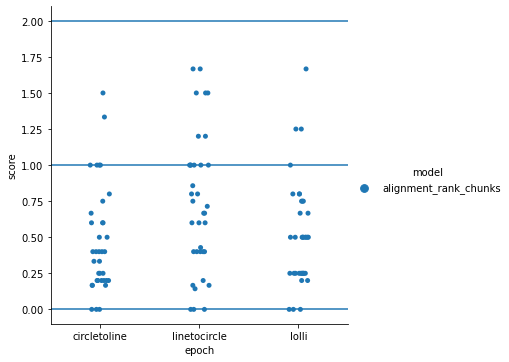

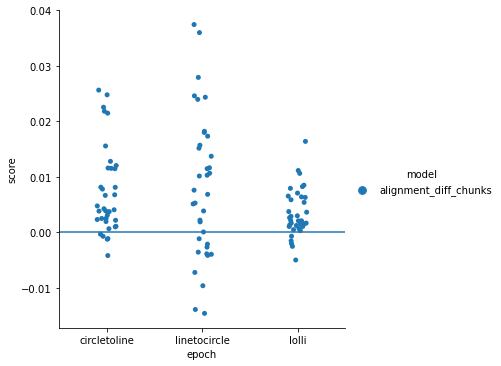

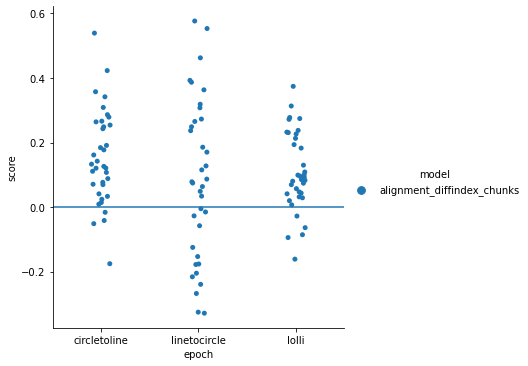

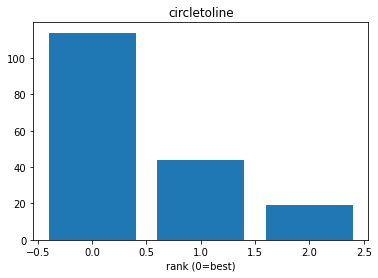

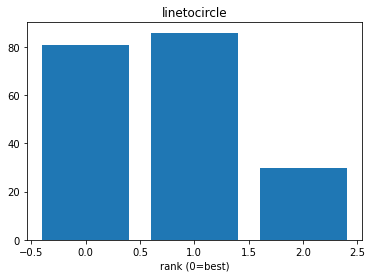

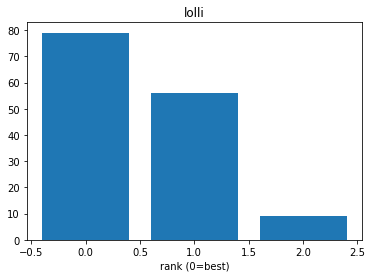

In [546]:
# One score for each epoch, based on aggregated rank

MBH.plot_summary_alignments()

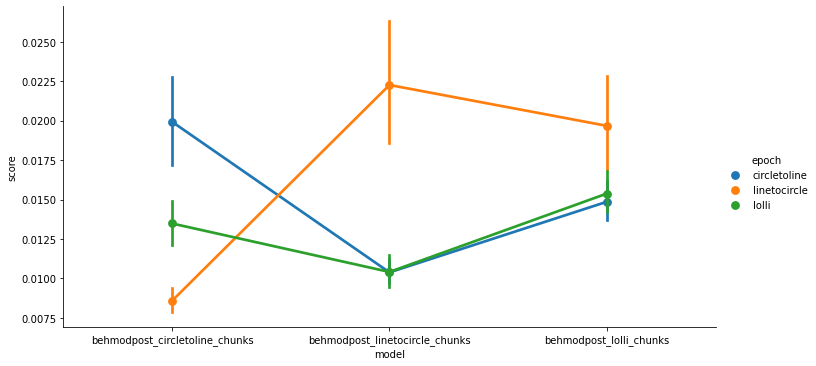

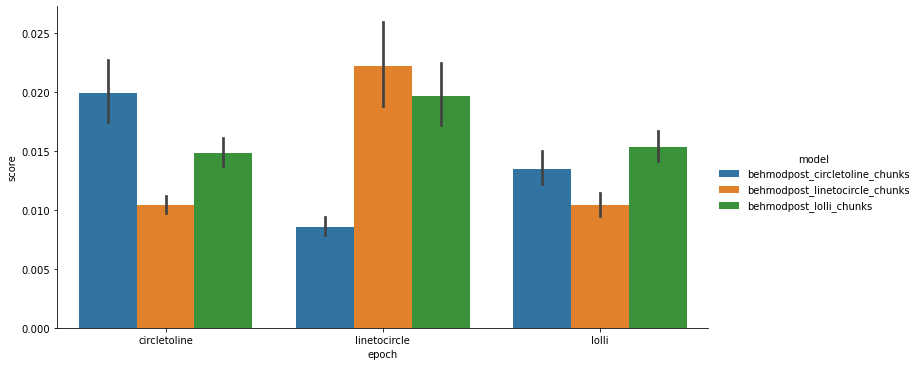

In [322]:
sns.catplot(data=DatFlatAgg, x="model", y="score", hue="epoch", kind="point", aspect=2)
sns.catplot(data=DatFlatAgg, x="epoch", y="score", hue="model", kind="bar", aspect=2)


##### PRUNE DATASET

In [583]:
# 1) Only tasks that have multiple circle and line (so can differentiate)
list_tasknames_good = []
mincir = 2
minlin = 2
for i in range(len(D.Dat)):
    P = D.parser_get_parser_helper(i)
    taskname = D.Dat.iloc[i]["unique_task_name"]
    o = P.ParsesBase[0]["objects_before_chunking"]
    
    ncir = len([oo for oo in o if oo[0]=="circle"])
    nlin = len([oo for oo in o if oo[0]=="line"])
    
    if ncir>=mincir and nlin>=minlin:
        list_tasknames_good.append(taskname)
list_tasknames_good = sorted(set(list_tasknames_good))
print(len(list_tasknames_good), list_tasknames_good)




32 ['mixture2-ss-1_1-573946', 'mixture2-ss-1_1-899756', 'mixture2-ss-2_1-092894', 'mixture2-ss-2_1-111763', 'mixture2-ss-2_1-121199', 'mixture2-ss-2_1-542064', 'mixture2-ss-2_1-597648', 'mixture2-ss-2_1-795134', 'mixture2-ss-2_1-824096', 'mixture2-ss-3_1-113921', 'mixture2-ss-3_1-510665', 'mixture2-ss-3_1-632820', 'mixture2-ss-3_1-801517', 'mixture2-ss-4_1-586590', 'mixture2-ss-4_1-780727', 'mixture2-ss-5_1-048096', 'mixture2-ss-5_1-064566', 'mixture2-ss-5_1-074007', 'mixture2-ss-5_1-085544', 'mixture2-ss-5_1-242738', 'mixture2-ss-5_1-331339', 'mixture2-ss-5_1-383971', 'mixture2-ss-5_1-389916', 'mixture2-ss-5_1-407986', 'mixture2-ss-5_1-610091', 'mixture2-ss-5_1-656860', 'mixture2-ss-5_1-767202', 'mixture2-ss-6_1-310208', 'mixture2-ss-6_1-402226', 'mixture2-ss-6_1-854929', 'mixture2-ss-6_1-948104', 'mixture2-ss-6_1-976501']


Done!, new len of dataset 518
Monkey priors (datasets):  ['circletoline', 'linetocircle', 'lolli']
Model scores (colnames):  ['behmodpost_circletoline_chunks', 'behmodpost_linetocircle_chunks', 'behmodpost_lolli_chunks']
Model alignments (colnames):  ['alignment_rank_chunks', 'alignment_diff_chunks', 'alignment_diffindex_chunks']
{'behmodpost_lolli_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_linetocircle_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_circletoline_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_rank_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_diff_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'alignment_diffindex_chunks': [<function <lambda> at 0x7efe3b0d1440>]}
{'behmodpost_lolli_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_linetocircle_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_circletoline_chunks': [<function <lambda> at 0x7efe3b0d1440>]}
{'alignment_rank_chunks': [

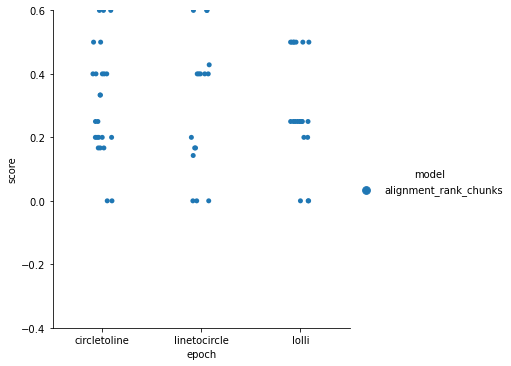

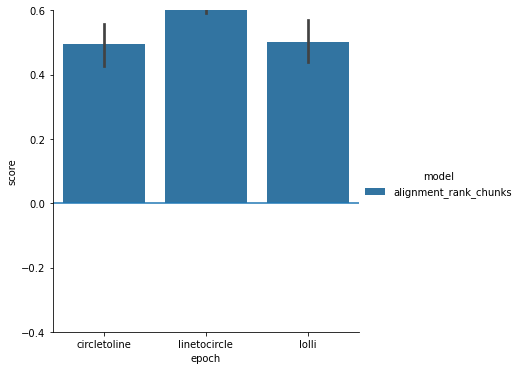

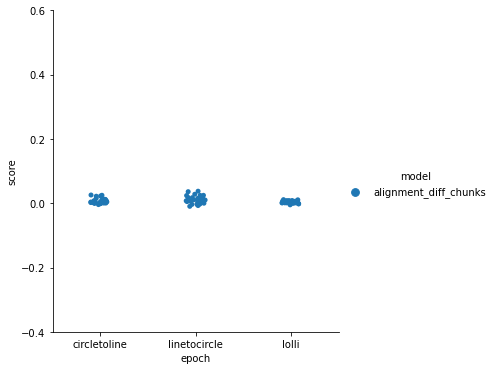

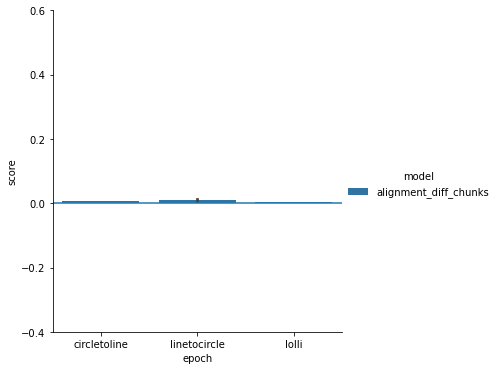

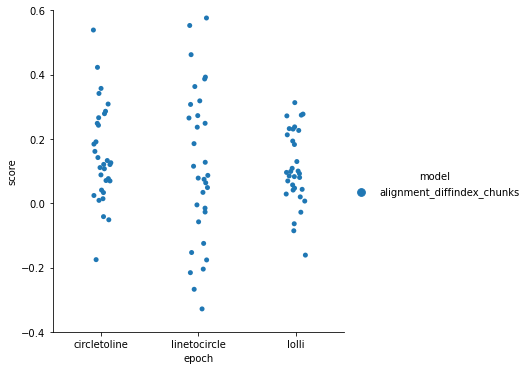

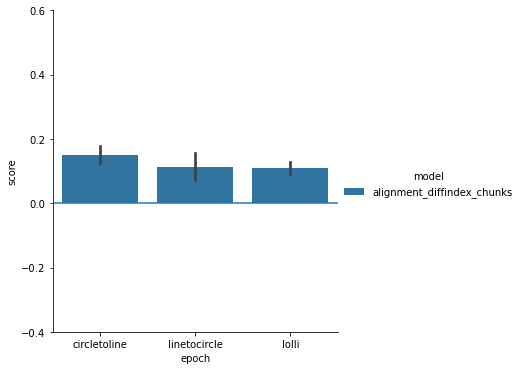

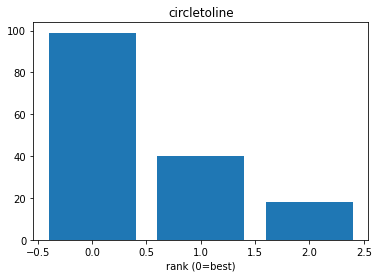

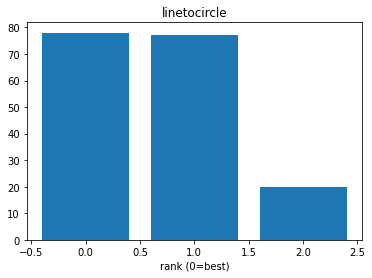

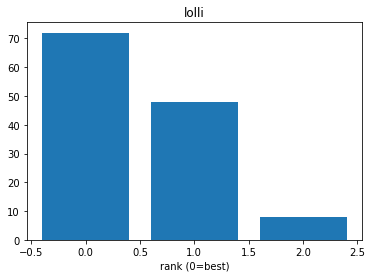

In [584]:
list_figs = MBH.plot_summary_alignments(list_tasknames_good, YLIM=[-0.4, 0.6])
for i, fig in enumerate(list_figs):
    path = f"{SDIR_FIGS}/summary_alignments_G3_2cir2lin_{i}.pdf"
    fig.savefig(path)



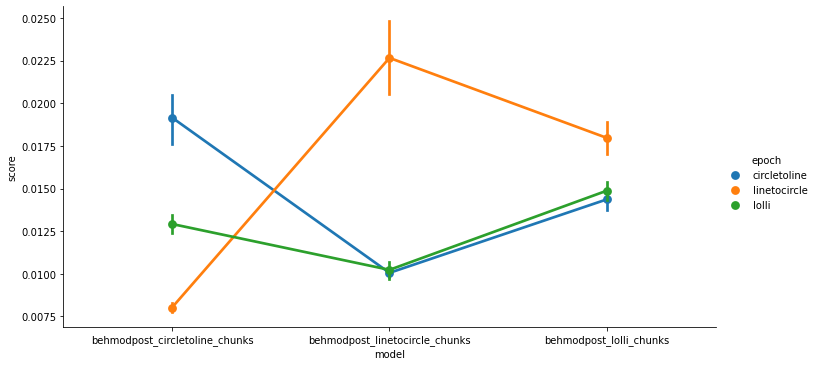

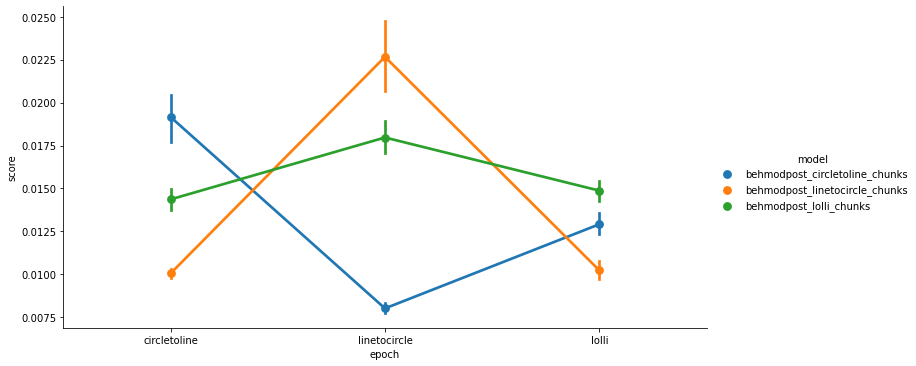

In [363]:
# Plot summary, only for characters that pass filter

dfthis = DatFlatAgg[DatFlatAgg["character"].isin(list_tasknames_good)].reset_index(drop=True)
sns.catplot(data=dfthis, x="model", y="score", hue="epoch", kind="point", aspect=2, ci=68)
sns.catplot(data=dfthis, x="epoch", y="score", hue="model", kind="point", aspect=2, ci=68)


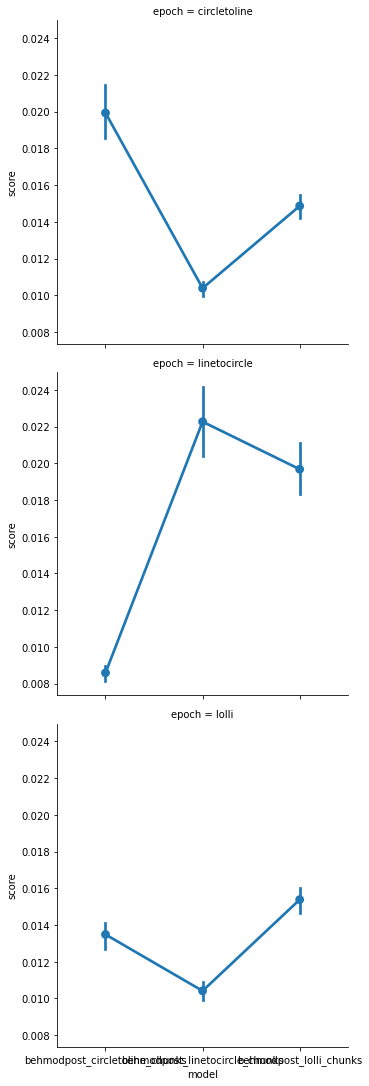

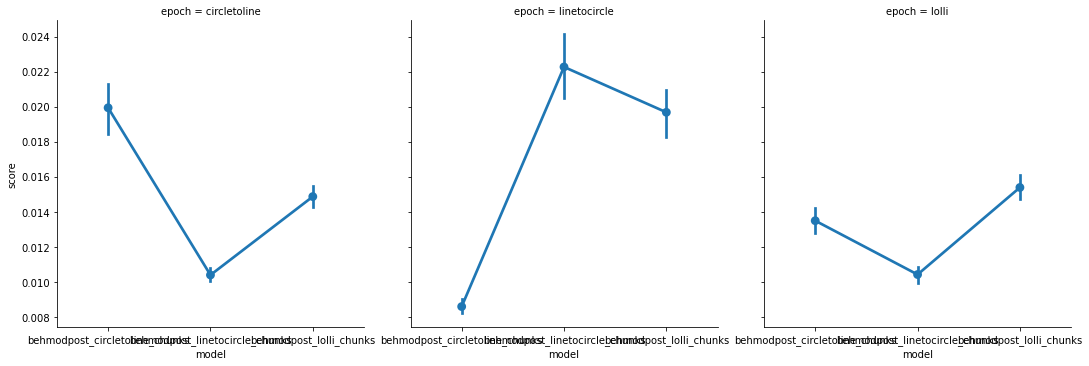

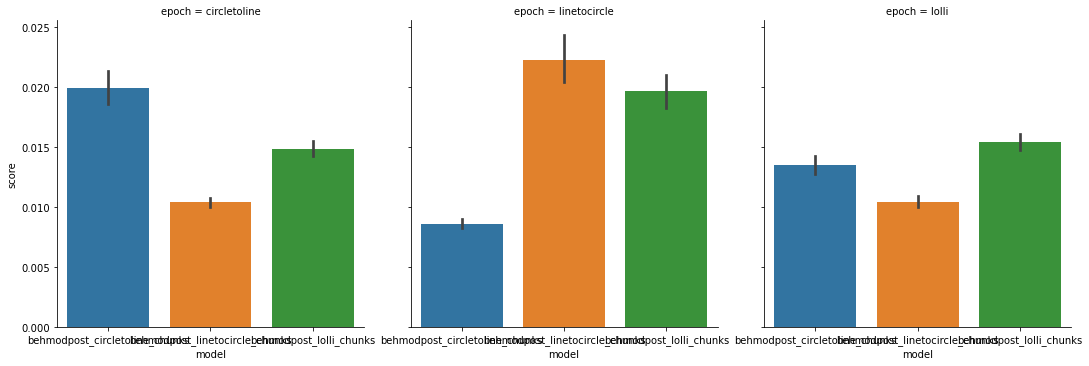

In [396]:
dfthis = DatFlatAgg
sns.catplot(data=dfthis, x="model", y="score", kind="point", sharey=True, aspect=1, ci=68, row="epoch")
sns.catplot(data=dfthis, x="model", y="score", kind="point", sharey=True, aspect=1, ci=68, col="epoch")
sns.catplot(data=dfthis, x="model", y="score", kind="box", sharey=True, aspect=1, ci=68, col="epoch")


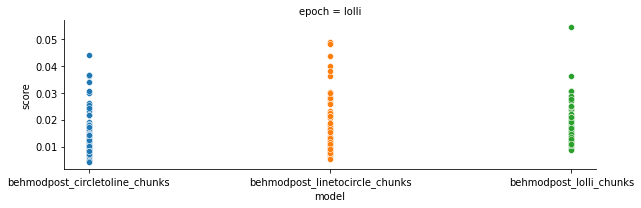

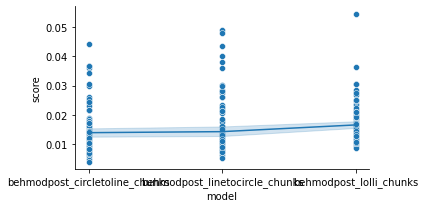

In [419]:
from pythonlib.tools.snstools import relplotOverlaid, relPlotOverlayLineScatter
relPlotOverlayLineScatter(DatFlatAgg, x="model", y="score", hue="model", col="epoch")

dfthis= DatFlatAgg[DatFlatAgg["epoch"] == "lolli"]
relPlotOverlayLineScatter(dfthis, x="model", y="score", hue="epoch", aspect=2)

##### Stats
ANOVA - interactin between rule(beh) and model?

In [400]:
dfthis = DatFlat
dfthis = DatFlat[DatFlat["character"].isin(list_tasknames_good)].reset_index(drop=True)
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('score ~ epoch * model', data=dfthis).fit()

In [401]:
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
# DatFlat

               sum_sq     df          F        PR(>F)
epoch        0.000315    2.0   2.706513  6.813945e-02
model        0.000170    2.0   1.455084  2.347615e-01
epoch:model  0.004421    4.0  18.966723  3.724111e-14
Residual     0.020803  357.0        NaN           NaN


In [402]:
pair_t = mod.t_test_pairwise('model')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
behmodpost_linetocircle_chunks-behmodpost_circletoline_chunks,-0.009430,0.001666,-5.661059,3.094771e-08,-0.012706,-0.006154,9.284313e-08,True
behmodpost_lolli_chunks-behmodpost_circletoline_chunks,-0.006732,0.001666,-4.041628,6.504448e-05,-0.010008,-0.003457,1.300847e-04,True
behmodpost_lolli_chunks-behmodpost_linetocircle_chunks,0.002698,0.001666,1.619430,1.062377e-01,-0.000578,0.005974,1.062377e-01,False


##### PLOT individual example trials

DONE Pancho_gridlinecircle_lolli chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_lolli chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_diff_chunks
Pancho_gridlinecircle_lolli  --  chunks
dataset: Pancho_gridlinecircle_lolli, indstrials, low to high value, based on alignment_diff_chunks
[83, 84, 118, 44, 38, 121, 4, 93, 88, 86, 39, 16, 127, 137, 104, 35, 115, 143, 51, 113, 70, 77, 50, 55, 12, 2, 105, 54, 124, 25, 89, 41, 74, 95, 116, 26, 102, 9, 80, 18, 20, 99, 33, 108, 37, 21, 100, 91, 3, 10, 112, 90, 136, 140, 114, 30, 119, 139, 109, 110, 87, 47, 135, 85, 42, 130, 6, 101, 53, 142, 96, 125, 141, 13, 59, 22, 134, 65, 73, 98, 32, 57, 19, 28, 68, 66, 75, 106, 8, 126, 79, 92, 128, 133, 67, 64, 117, 123, 132, 29, 23, 62, 63, 72, 36, 52, 34, 7

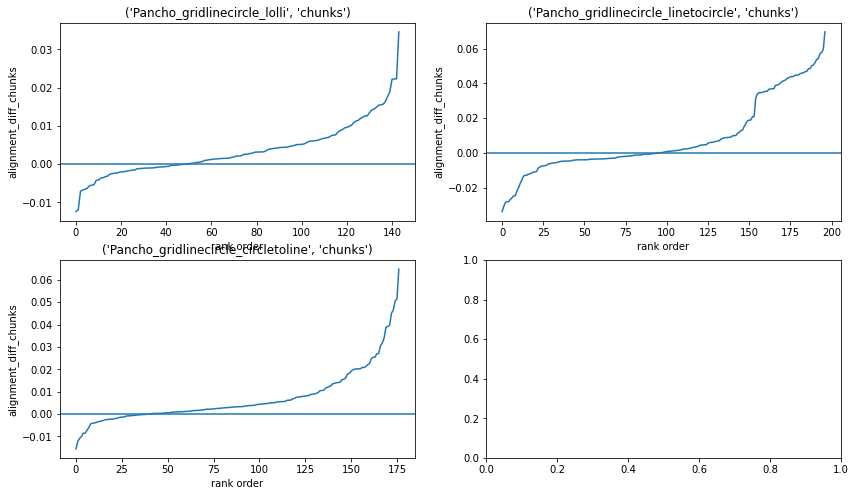

In [439]:
# list trials
MBH.analy_compute_alignment_wrapper(ploton=True)

In [643]:
sdir = f"{SDIR_FIGS}/indiv_trials"
os.makedirs(sdir, exist_ok=True)

##### Given partial name of characetr, plot all its trials

mixture2-ss-6_1-854929
27
62
106
58
73
91
115
172
2
30
60
88
128
144
['lolli', 'lolli', 'lolli', 'linetocircle', 'linetocircle', 'linetocircle', 'linetocircle', 'linetocircle', 'circletoline', 'circletoline', 'circletoline', 'circletoline', 'circletoline', 'circletoline']
[27, 62, 106, 58, 73, 91, 115, 172, 2, 30, 60, 88, 128, 144]
____  lolli 27
(Row orders of pares plots:  ['likeli', 'prior']
This trialtuple ('Pancho', 'gridlinecircle', 'lolli', '210901-1-399')
class/rule:  chunks circletoline
class/rule:  chunks linetocircle
class/rule:  chunks lolli
SKIPPING dset (doesnt match input):  Pancho_gridlinecircle_linetocircle
SKIPPING dset (doesnt match input):  Pancho_gridlinecircle_circletoline


KeyboardInterrupt: 

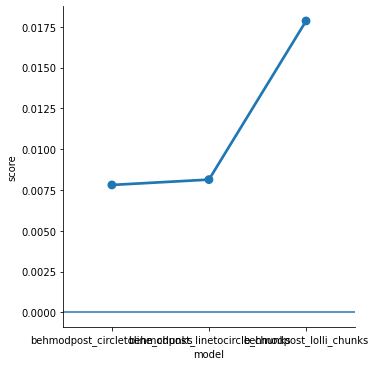

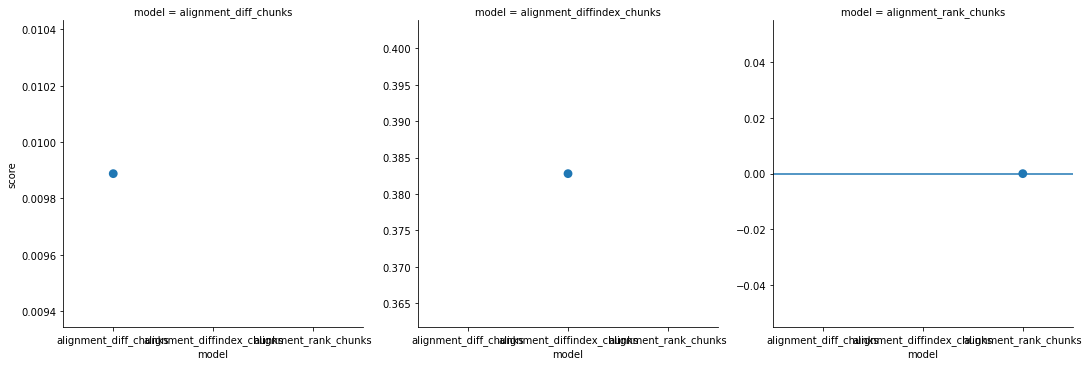

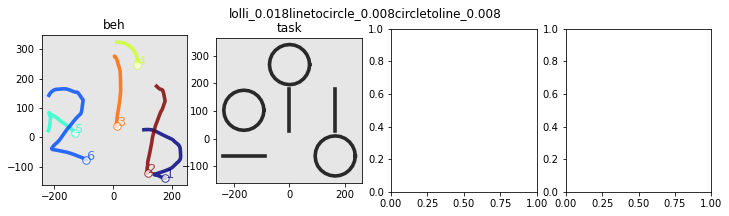

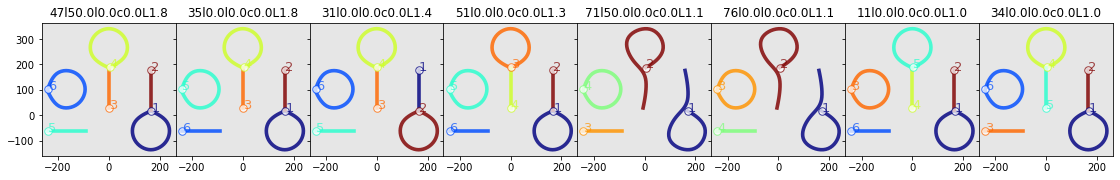

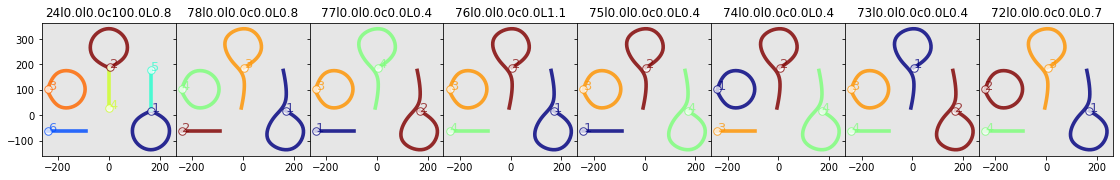

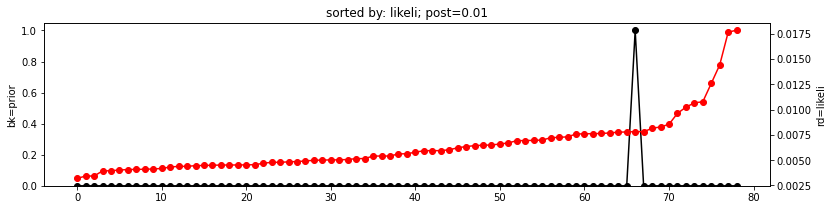

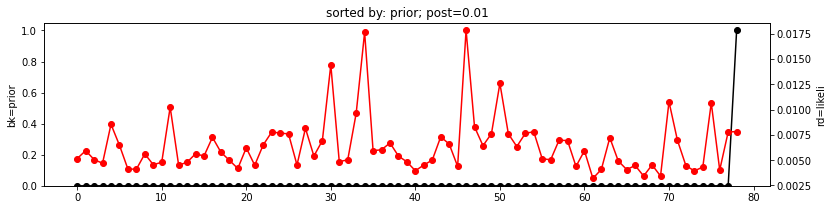

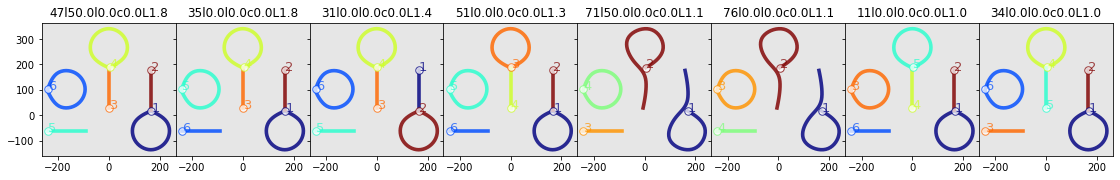

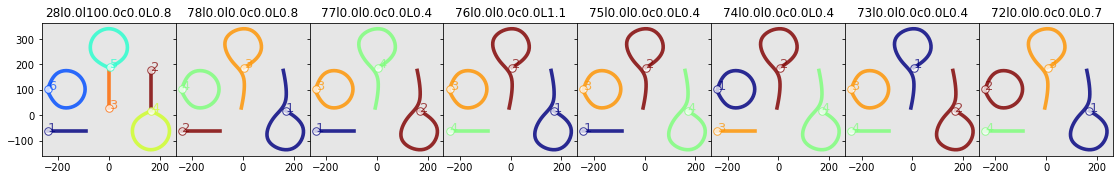

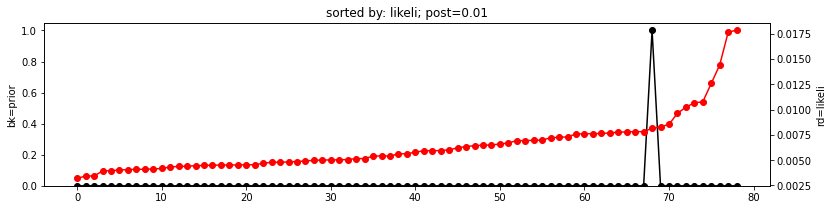

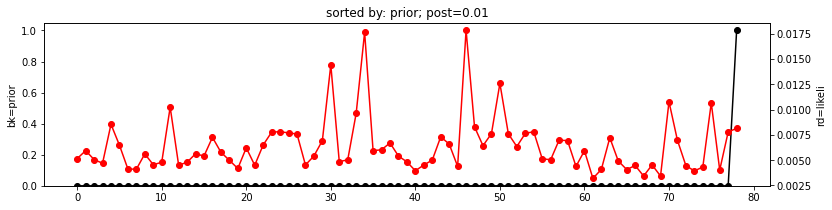

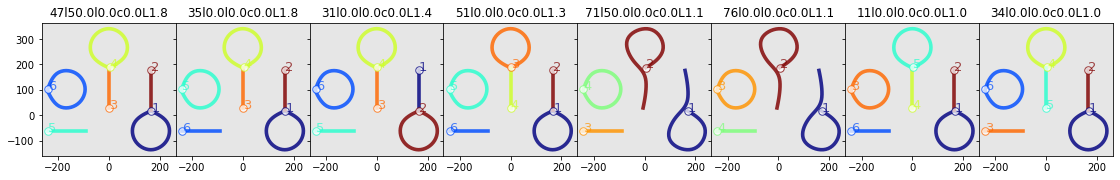

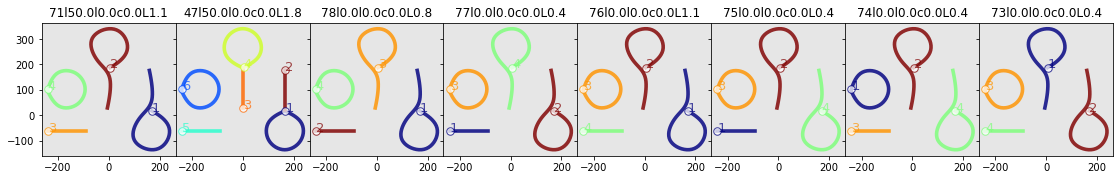

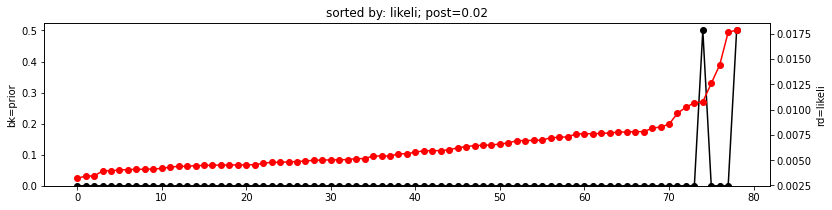

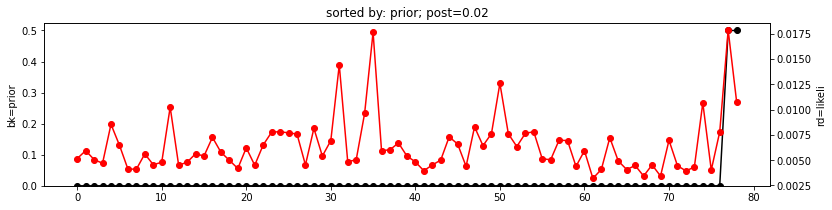

In [665]:
# 0) Given a character, plot all trials or the best one.
TAKE_BEST = False

char = "54929"
for i in range(len(D.Dat)):
    if char in D.Dat.iloc[i]["character"]:
        char = D.Dat.iloc[i]["character"]
        break
print(char)

idx_list = []
rulesthis = []
for dset, mclass, D, H, list_rule in MBH.iter_test_dat():
    
    dfthis = D.Dat[D.Dat["character"]==char]
    if TAKE_BEST:
        # Tkae the single best score
            idx = dfthis.iloc[[dfthis["alignment_diff_chunks"].argmax()]].index.tolist()[0]
            print(idx)
            idx_list.append(idx)
            rulesthis.append(D.rules(True)[0])
    else:
        for idx in dfthis.index.tolist():
            # Take each trial
            print(idx)
            idx_list.append(idx)
            rulesthis.append(D.rules(True)[0])
    
print(rulesthis)
print(idx_list)

for rule, idx in zip(rulesthis, idx_list):
    print("____ ", rule, idx)
    figs = plot_scores_this_trial(rule, idx)

    from pythonlib.tools.plottools import saveMultToPDF
    for i, f in enumerate(figs[:2]):
        f.savefig(f"{sdir}/dsetrule_{rule}-indtrial_{idx}_{i}.pdf")
    saveMultToPDF(f"{sdir}/dsetrule_{rule}-indtrial_{idx}_{2}", figs[2:])
    

In [655]:

# 1) For this trial, plot scores across models, and their example parses
dset_rule = "lolli"
indtrial = 122

def get_character(MBH, dset_rule, indtrial):
    # get trialcode
    for dset, mclass, D, H, list_rule in MBH.iter_test_dat():
        if D.rules(True)[0]==dset_rule:
            return D.Dat.iloc[indtrial]["character"]
    assert False
    
def get_trialcode(MBH, dset_rule, indtrial):
    # get trialcode
    for dset, mclass, D, H, list_rule in MBH.iter_test_dat():
        if D.rules(True)[0]==dset_rule:
            return D.Dat.iloc[indtrial]["trialcode"]
    assert False

def plot_scores_this_trial(dset_rule, indtrial):
    # 1) Plot scores
    tc = get_trialcode(MBH, dset_rule, indtrial)
    
    list_figs = []
    dfthis = DatFlat[DatFlat["trialcode"]==tc]
    dfthis = dfthis.sort_values("model") # so in alpha order
    assert len(dfthis)==len(list_rule), "shuild be one scoere per model"
    fig = sns.catplot(data=dfthis, x="model", y="score", kind="point")
    plt.axhline(0)
    list_figs.append(fig)
    
    # 1b) Plot alignments
    dfthis = DatFlatAlignment[DatFlatAlignment["trialcode"]==tc]
    dfthis = dfthis.sort_values("model") # so in alpha order
    assert len(dfthis)==len(list_rule), "shuild be one scoere per model"
    fig = sns.catplot(data=dfthis, x="model", y="score", kind="point", sharey=False, col="model")
    plt.axhline(0)
    list_figs.append(fig)
    
    # 2) Plot parses
    figs = MBH.plot_overview_trial(dset_rule, indtrial)
    list_figs.extend(figs)
    
    # Make sure figs are flat
    list_figs_out =[]
    for f in list_figs:
        if isinstance(f, list):
            for ff in f:
                list_figs_out.append(ff)
        else:
            list_figs_out.append(f)
        
    return list_figs_out


##### 1. For each dataset, plot its score under 2 competeing models
Note: currently plats N datsaets, but only works for 2 models

Done!, new len of dataset 518
['behmodpost_linetocircle_chunks', 'behmodpost_lolli_chunks'] ['linetocircle', 'lolli']
mod2_minus_mod1: behmodpost_lolli_chunks - behmodpost_linetocircle_chunks
{'behmodpost_lolli_chunks': ['mean'], 'behmodpost_linetocircle_chunks': ['mean'], 'mod2_minus_mod1': ['mean']}
linetocircle
lolli
Index(['circletoline', 'linetocircle', 'lolli'], dtype='object', name='epoch')


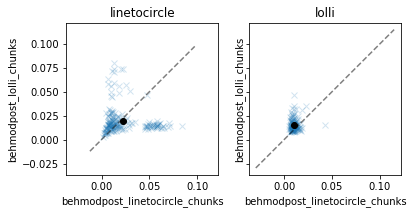

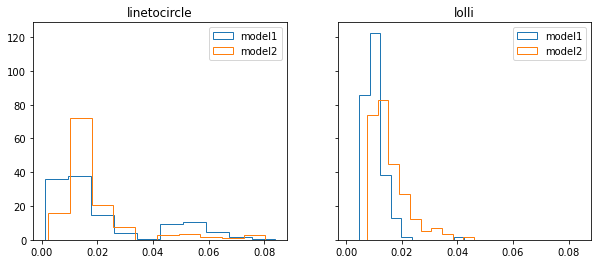

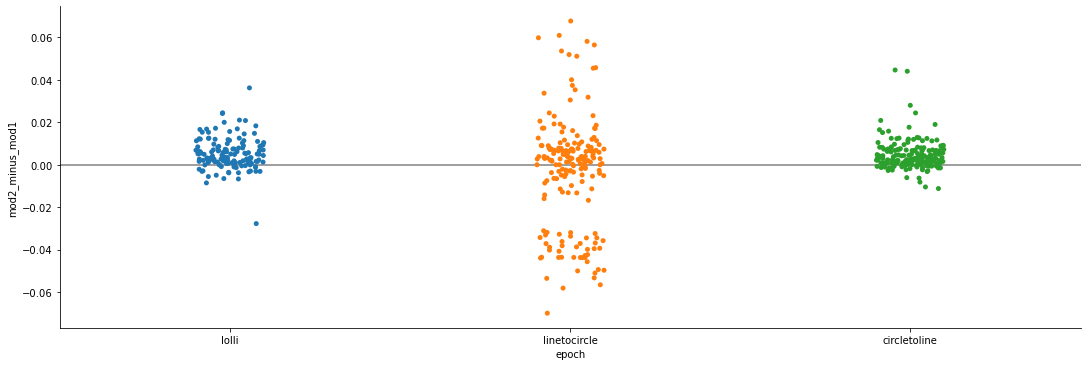

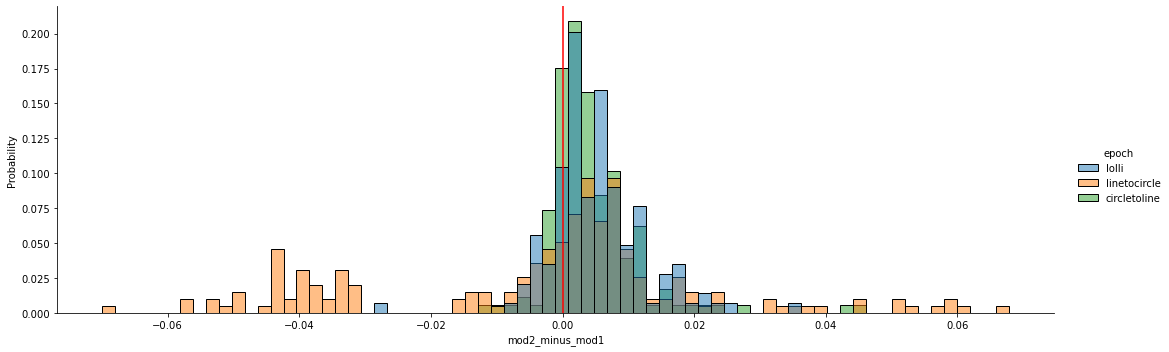

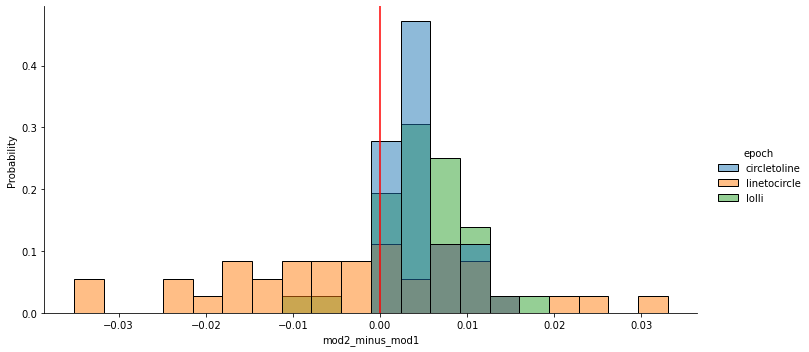

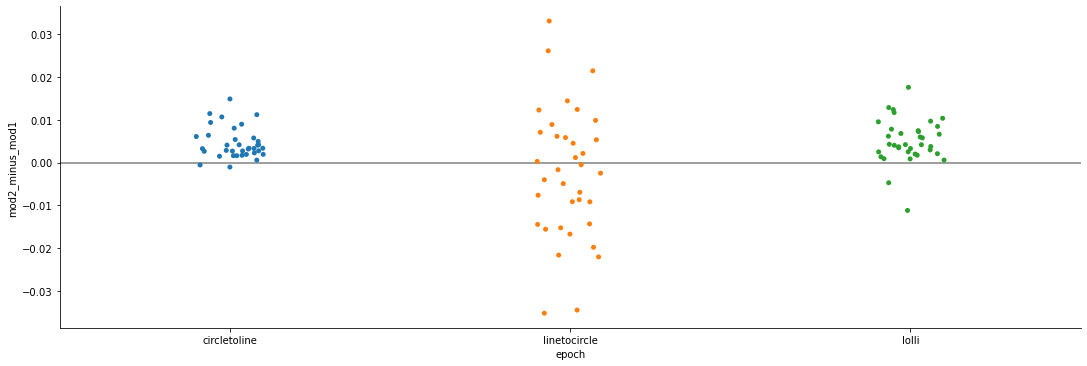

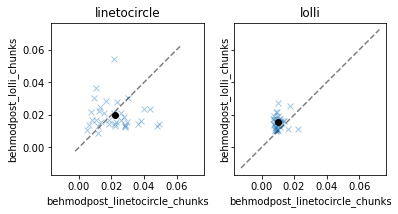

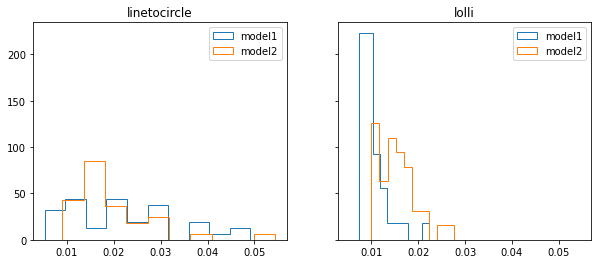

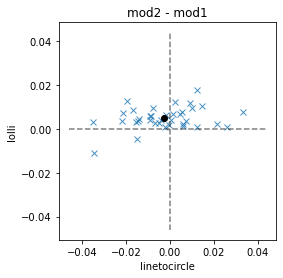

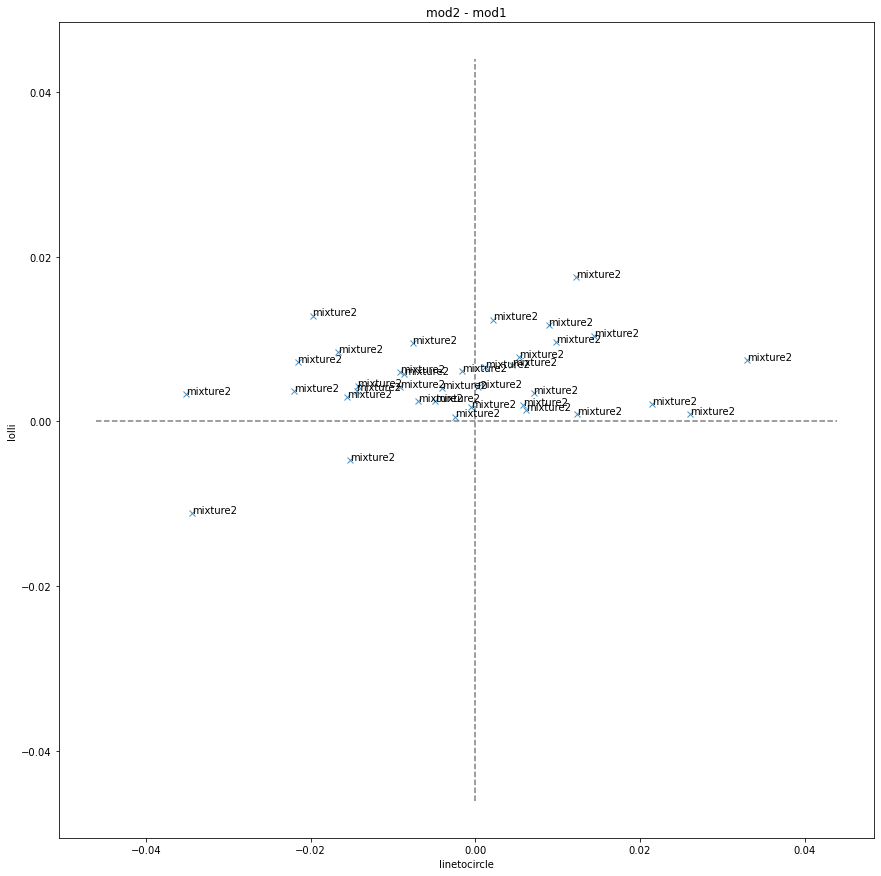

In [282]:
# concatting dasets (delete lower cell if works)
from pythonlib.dataset.beh_model_comparison import plots_cross_prior_and_model
from pythonlib.dataset.analy_dlist import concatDatasets

GROUPING_LEVELS = rule_list
HACK = True
if HACK:
#     GROUPING_LEVELS = ["circletoline", "linetocircle"]
    GROUPING_LEVELS = ["linetocircle", "lolli"]

Dthis = MBH.extract_concatenated_dataset()

# Combine datasets so that can plot in aggregate
GROUPING = "epoch"
for mclass in MBH.ListMclass:
    if not HACK:
        GROUPING_LEVELS = MBH.DictMrule[mclass]
    list_col_names = [MBH.ColNames.colnames_score(mclass, r) for r in GROUPING_LEVELS]
    plots_cross_prior_and_model(Dthis.Dat, GROUPING, GROUPING_LEVELS, list_col_names);    

##### 2. Details within each model

In [ ]:
MBH_load.DictTestDH[("Red_lines5_straight", mclass)]["H"].plot_overview_results("straight");
MBH_load.DictTestDH[("Red_lines5_straight", mclass)]["H"].plot_overview_results("bent");

##### 3. Bar plots comparing multiple alternative model classes (summary scores) [i.e., alignment]
NOTE: requires only 2 models, and each row of dataset aligns with one or the other

In [34]:
Dtest = MBH_load.extract_concatenated_dataset()


Done!, new len of dataset 569


In [ ]:
from pythonlib.dataset.beh_model_comparison import plots_cross_prior_and_model_combined, ColNames

# Dthis = Dall
Dthis = Dtest

GROUPING = "epoch"
if expt=="lines5":
    GROUPING_LEVELS = ["straight", "bent"]
    # list_mclass = ["lines5", "mkvsmk"]
    list_mrule = ["straight", "bent"]
    # CN = ColNames(list_mclass, list_mrule)
elif expt=="gridlinecircle":
    GROUPING_LEVELS = ["linetocircle", "circletoline"]
    # list_mclass = ["lines5", "mkvsmk"]
    list_mrule = GROUPING_LEVELS
    # CN = ColNames(list_mclass, list_mrul
    
list_mclass = MBH_load.ListMclass

plots_cross_prior_and_model_combined(Dthis, GROUPING, GROUPING_LEVELS, list_mclass, list_mrule)

#### Plots across model classes





In [35]:
MBH = MBH_load

dataset: ('Pancho_gridlinecircle_lolli', 'chunks') . modelrule:  lolli
dataset: ('Pancho_gridlinecircle_lolli', 'chunks') . modelrule:  linetocircle
dataset: ('Pancho_gridlinecircle_lolli', 'chunks') . modelrule:  circletoline
dataset: ('Pancho_gridlinecircle_linetocircle', 'chunks') . modelrule:  lolli
dataset: ('Pancho_gridlinecircle_linetocircle', 'chunks') . modelrule:  linetocircle
dataset: ('Pancho_gridlinecircle_linetocircle', 'chunks') . modelrule:  circletoline
dataset: ('Pancho_gridlinecircle_circletoline', 'chunks') . modelrule:  lolli
dataset: ('Pancho_gridlinecircle_circletoline', 'chunks') . modelrule:  linetocircle
dataset: ('Pancho_gridlinecircle_circletoline', 'chunks') . modelrule:  circletoline


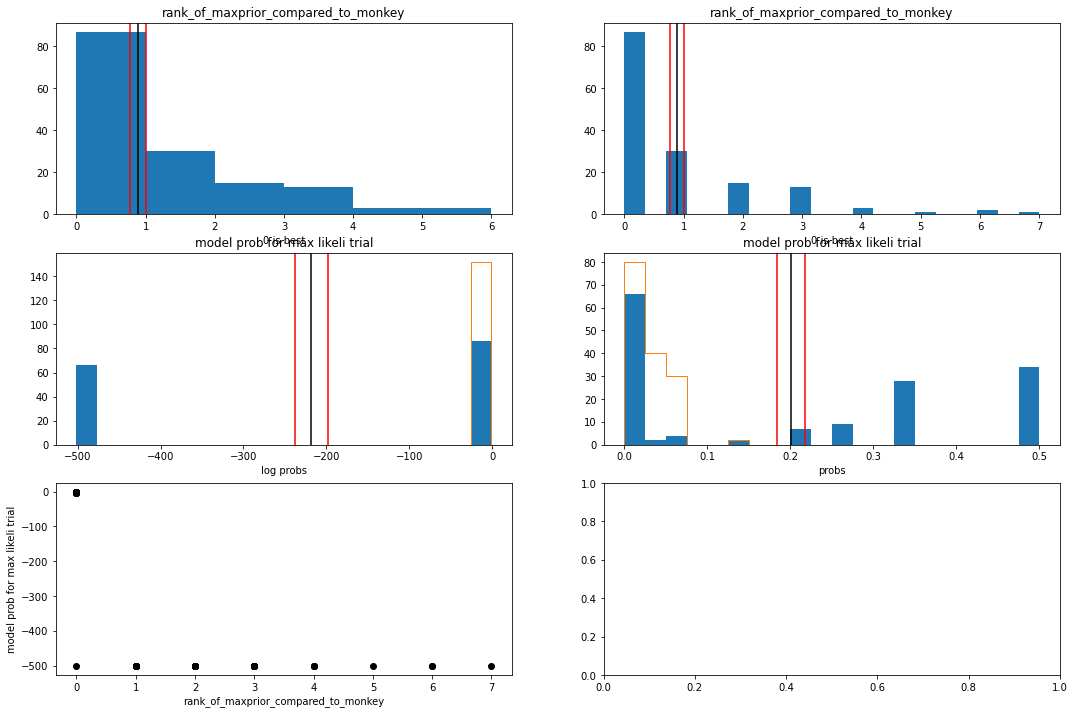

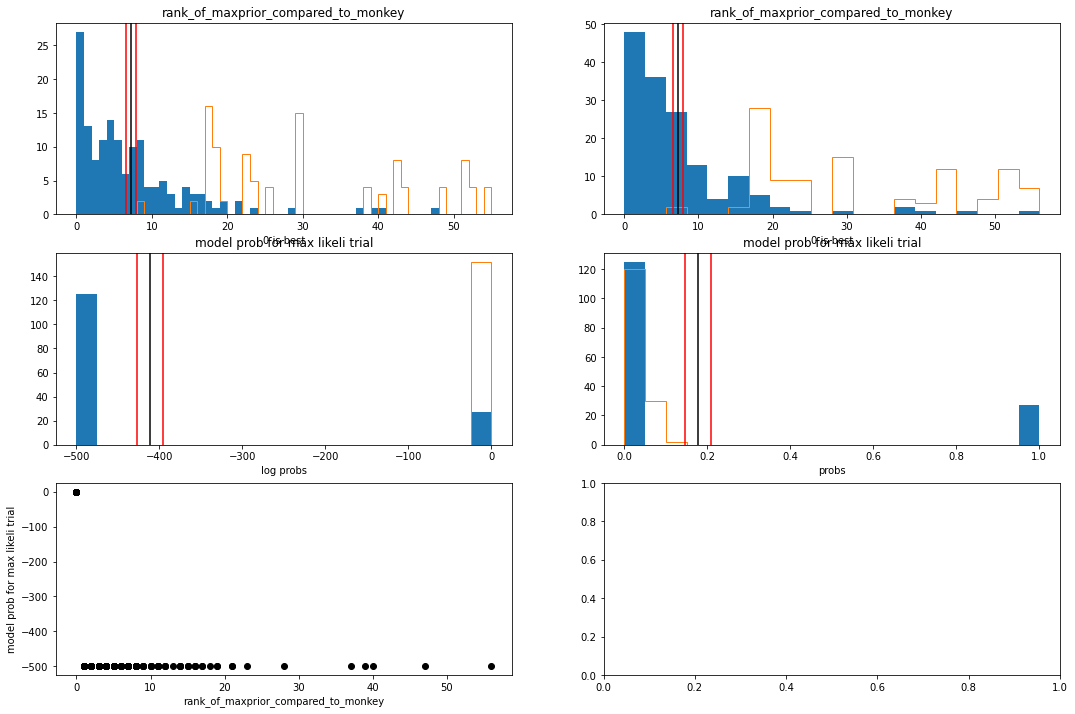

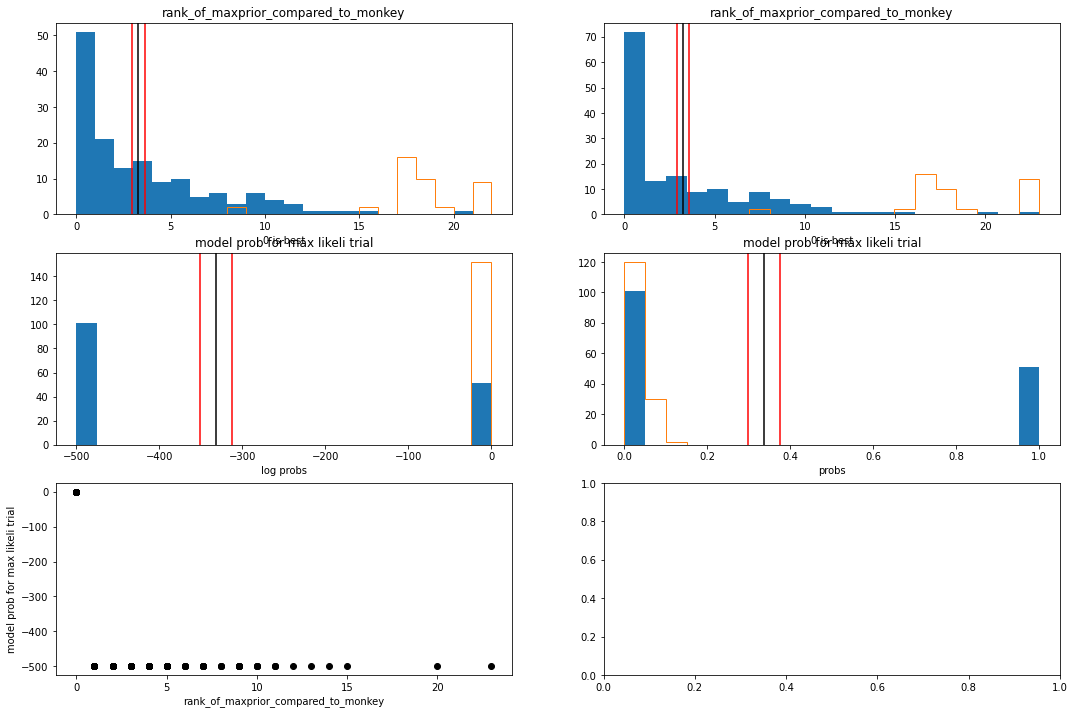

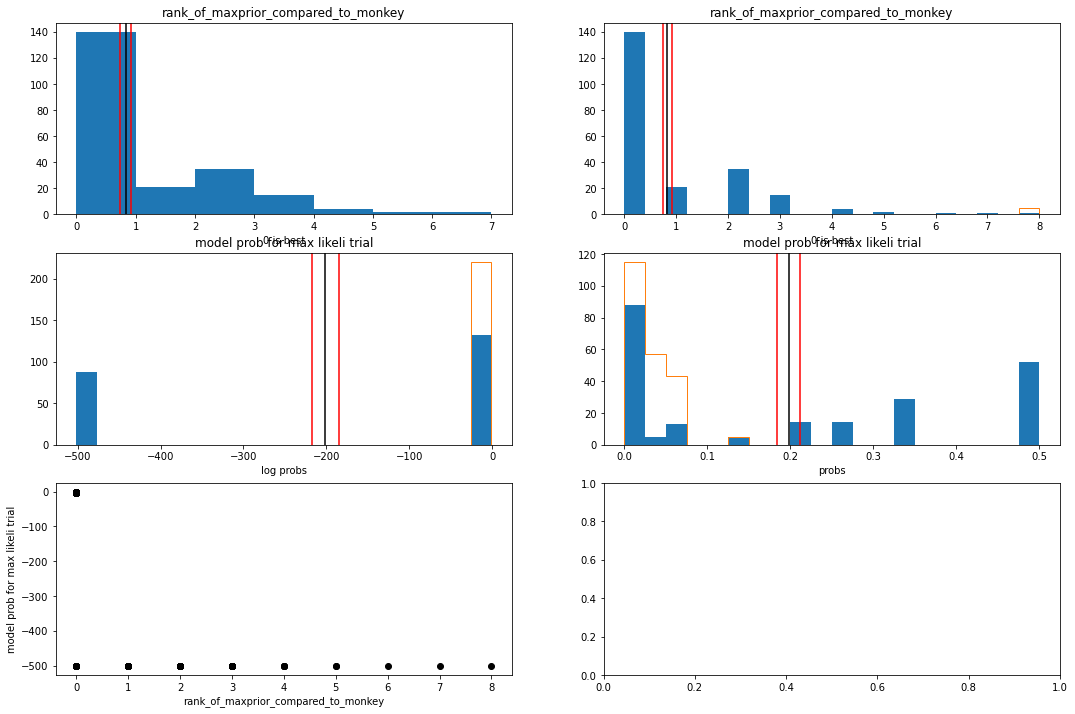

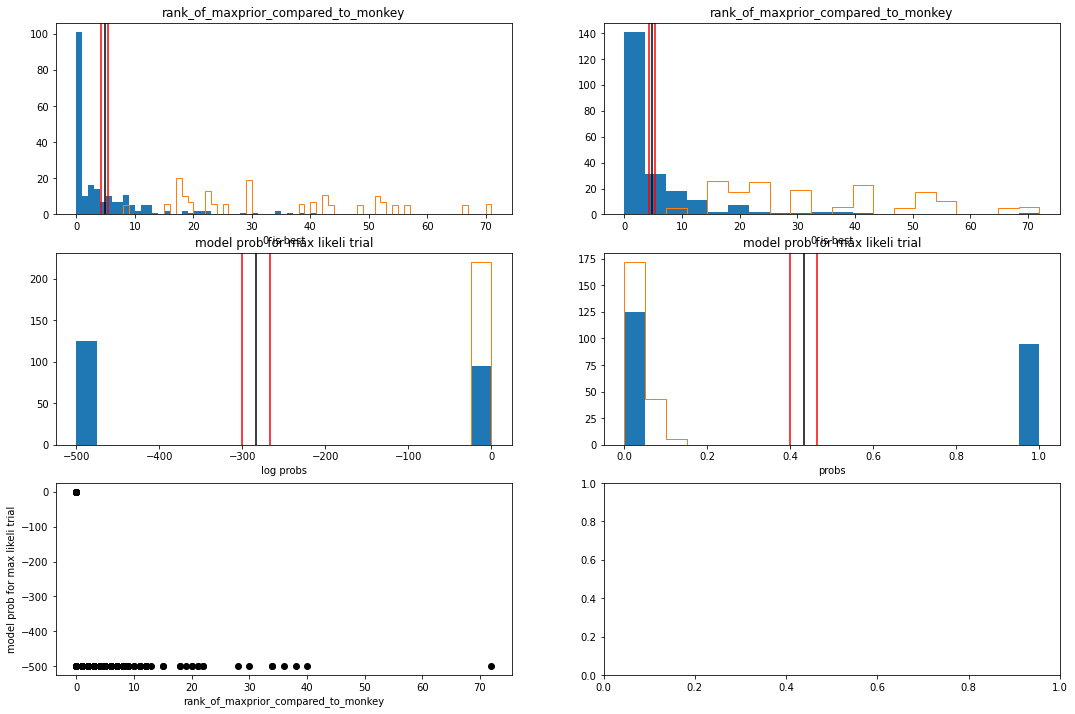

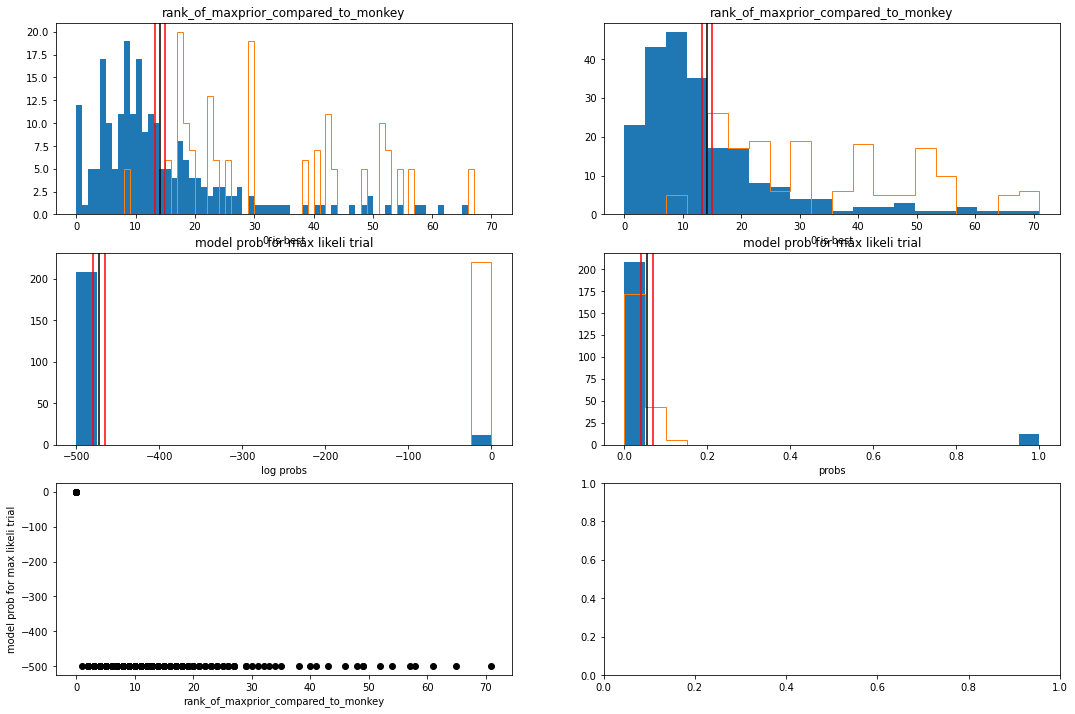

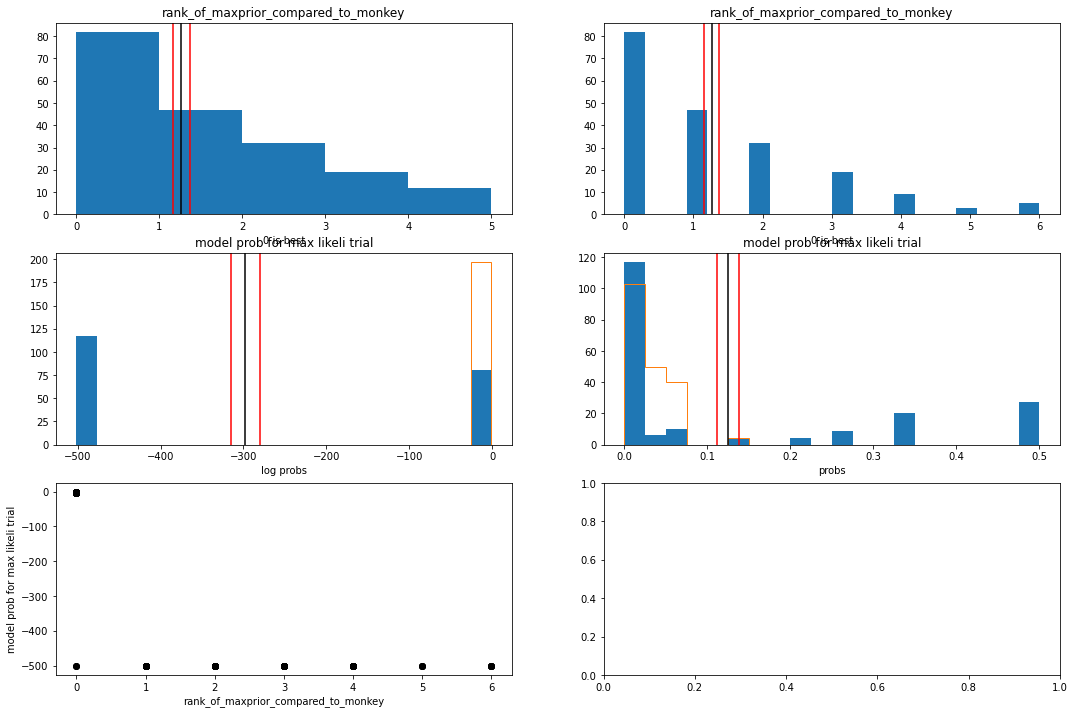

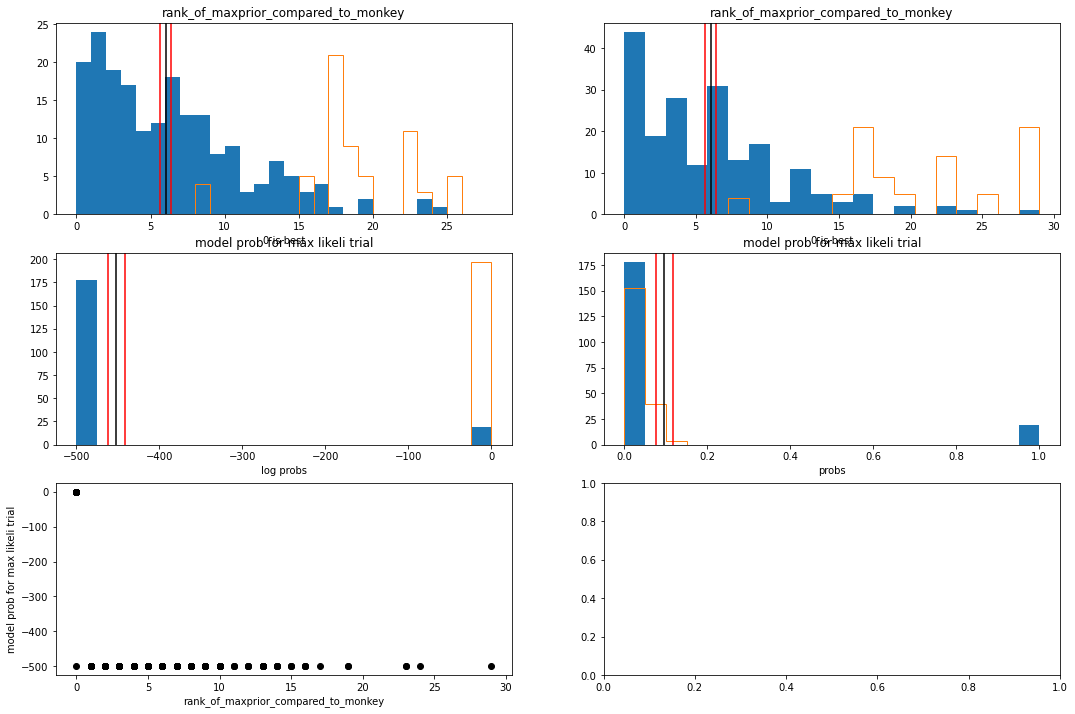

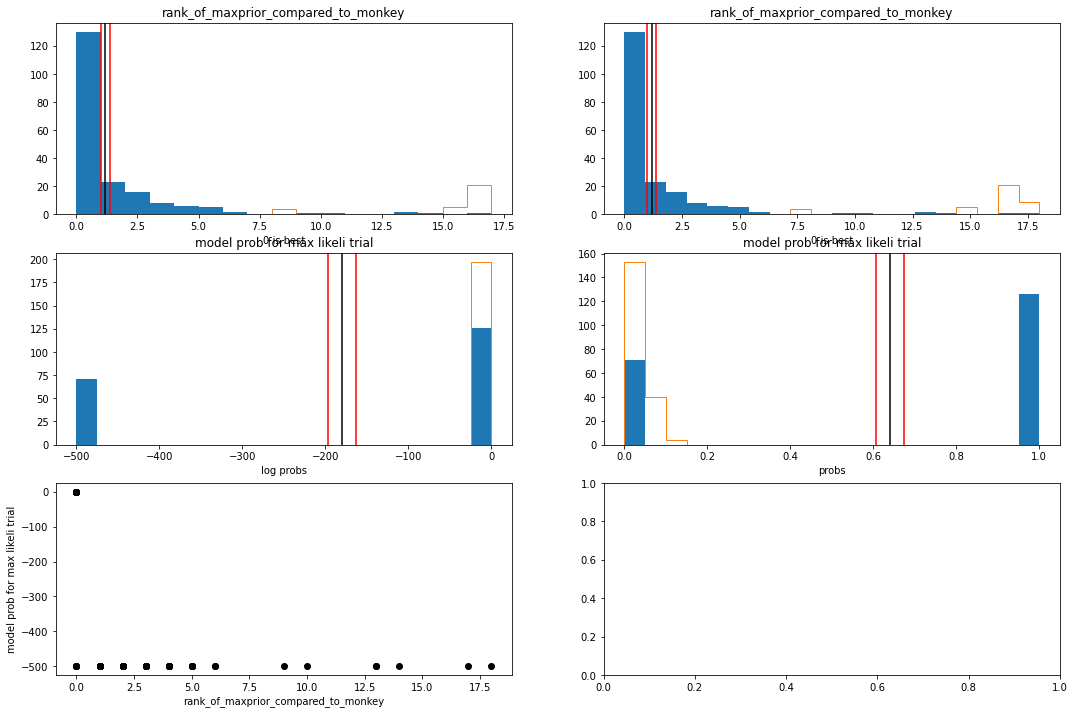

In [45]:
MBH.plot_datxmodel_overview_results()

In [ ]:
if False:
    # OBSOLETE - use alignmetn,a dn code for sorting those, isntad. [DONE]
    # 1a) Pick out tasks where show most consistency, and most difference across models (for both likeli and prior)
    # list_dset = list(MBH.DictTestD.keys())
    dset = "Red_lines5_straight"
    D = MBH.DictTestD[dset]
    # mclass = MBH.ListMclass[0]
    mclass = "mix_features_bd"
    print("dataset:", dset)
    print("mclass:", mclass)

    # H = MBH.DictTestDH[(dset, mclass)]["H"]
    # D = MBH.DictTestDH[(dset, mclass)]["D"]

    coldiff = MBH.ColNames.colnames_minus_usingnames(mclass)
    print(coldiff)
    np.argsort(D.Dat[coldiff].values)

##### [important] compute alignemnt fro each row of all data

DONE Pancho_gridlinecircle_lolli chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_lolli chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_lolli chunks alignment_diffindex_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_linetocircle chunks alignment_diffindex_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_rank_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_diff_chunks
DONE Pancho_gridlinecircle_circletoline chunks alignment_diffindex_chunks
Pancho_gridlinecircle_lolli  --  chunks
dataset: Pancho_gridlinecircle_lolli, indstrials, low to high value, based on alignment_diffindex_chunks
[83, 84, 38, 118, 93, 121, 44, 88, 16, 39, 4, 127, 86, 35, 51, 115, 143, 77, 12, 113, 50, 105, 104, 70, 54, 2, 55, 41, 124, 89, 25, 116, 137, 95, 26, 74, 9, 80, 102, 18, 99, 20, 108, 37, 21, 33, 100, 91, 3, 10, 112, 90, 136, 140, 114, 119, 

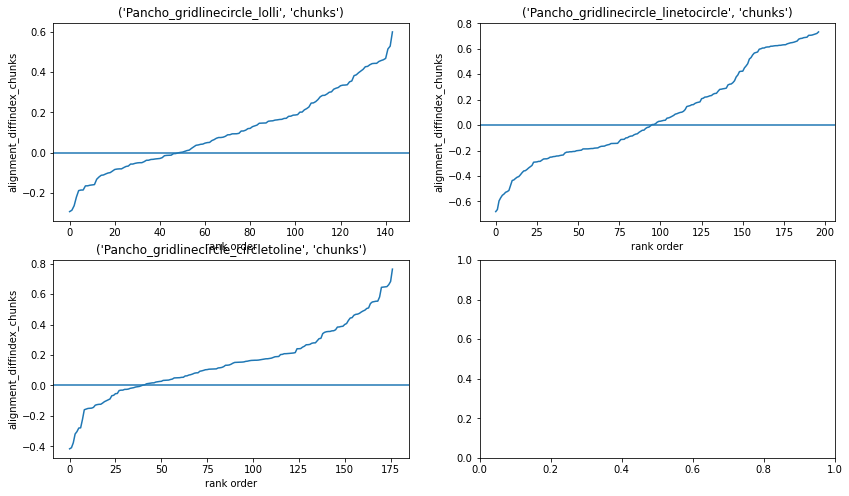

In [525]:
MBH.analy_compute_alignment_wrapper(ploton=True, plot_alignment_ver="diffindex")

(Row orders of pares plots:  ['likeli', 'prior']
SKIPPING dset (doesnt match input):  Pancho_gridlinecircle_lolli
This trialtuple ('Pancho', 'gridlinecircle', 'linetocircle', '210823-1-476')
Dataset: Pancho_gridlinecircle_linetocircle
alignment_diff_chunks 0.06960585438738032
alignment_rank_chunks 0
class/rule:  chunks circletoline
class/rule:  chunks linetocircle
class/rule:  chunks lolli
-- BASE PARSE INFO:
0 -- baseline --hier: [0, 1, 2, 3, 4, 5] -- {0: False, 1: [False, False, False, False, False, False]} --chunks: [0, 1, 2, 3, 4, 5]
1 -- linetocircle --hier: [[1, 2, 4, 5], [0, 3]] -- {0: True, 1: [False, False]} --chunks: [0, 1, 2, 3, 4, 5]
2 -- circletoline --hier: [[0, 3], [1, 2, 4, 5]] -- {0: True, 1: [False, False]} --chunks: [0, 1, 2, 3, 4, 5]
3 -- lolli --hier: [[0, 1], [3, 2], [4], [5]] -- {0: False, 1: [False, False, False, False]} --chunks: [0, 1, 2, 3, 4, 5]
4 -- lolli --hier: [0, 1, 2, 3] -- {0: False, 1: [False, False, False, False]} --chunks: [[0, 1], [3, 2], [4], [5]

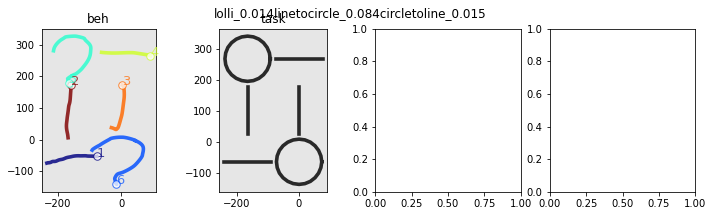

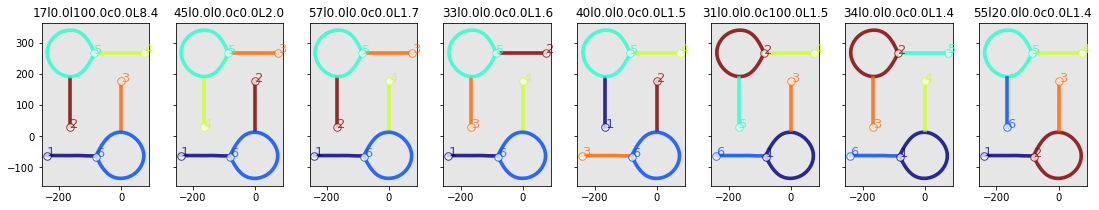

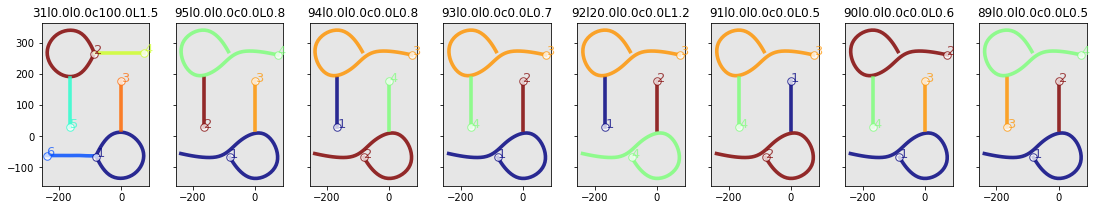

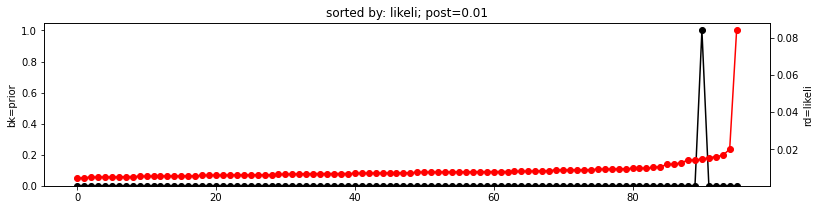

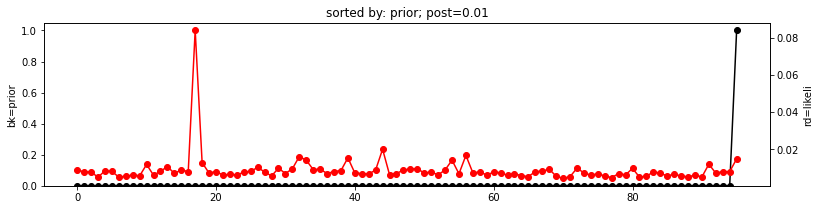

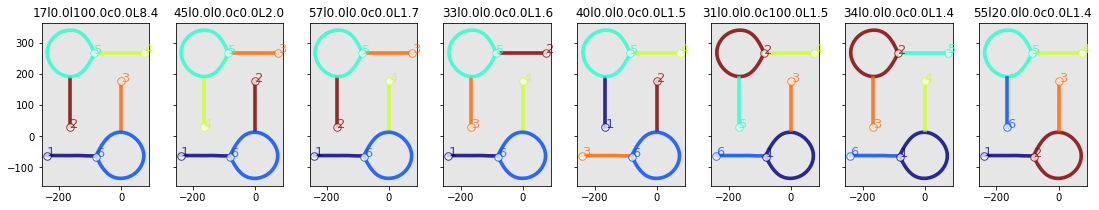

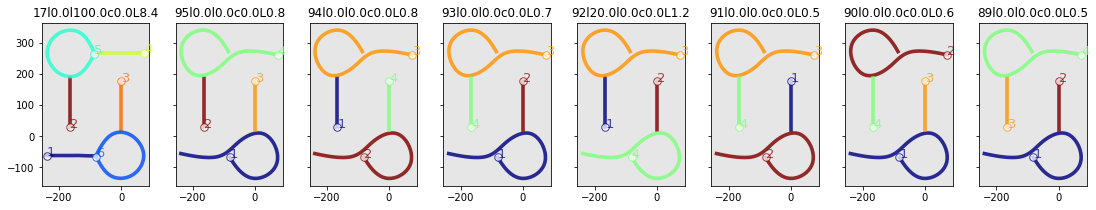

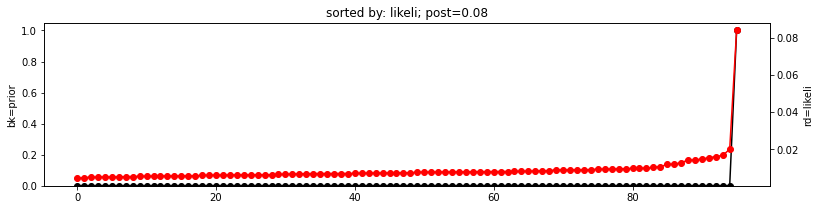

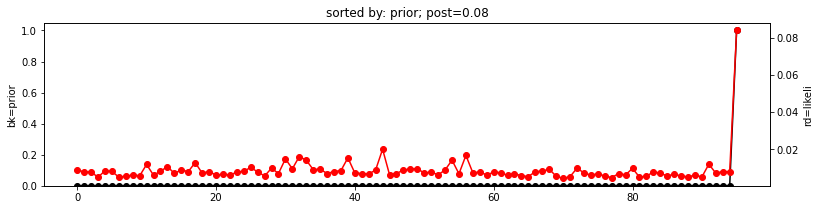

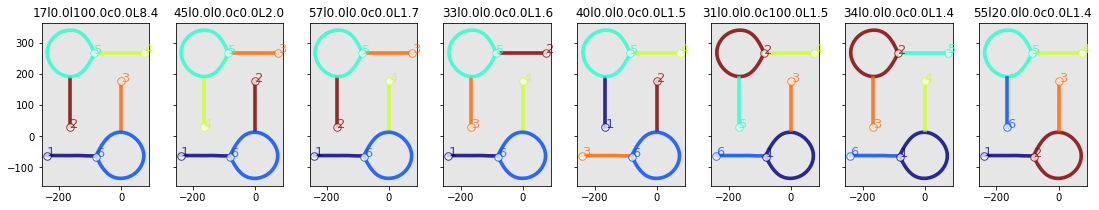

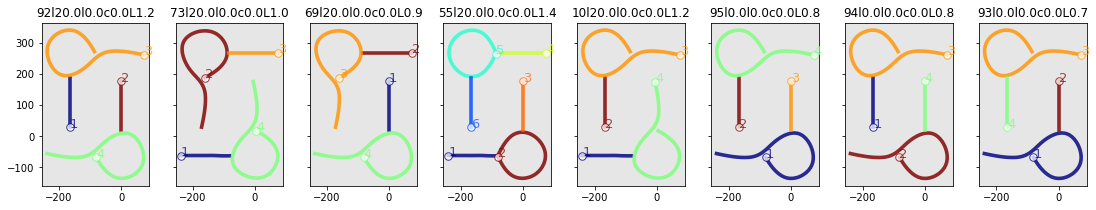

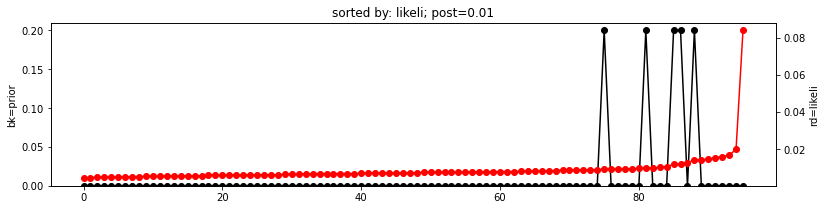

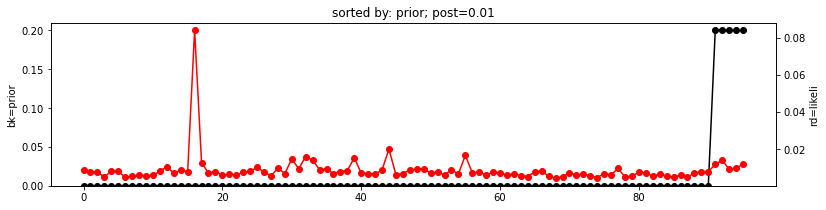

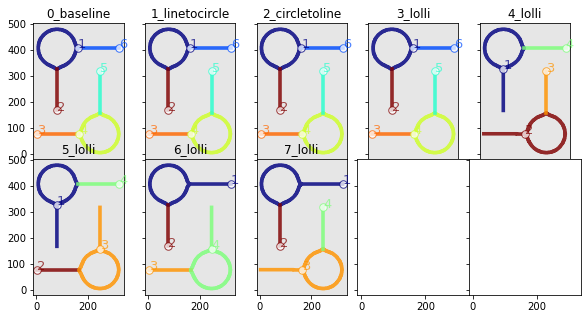

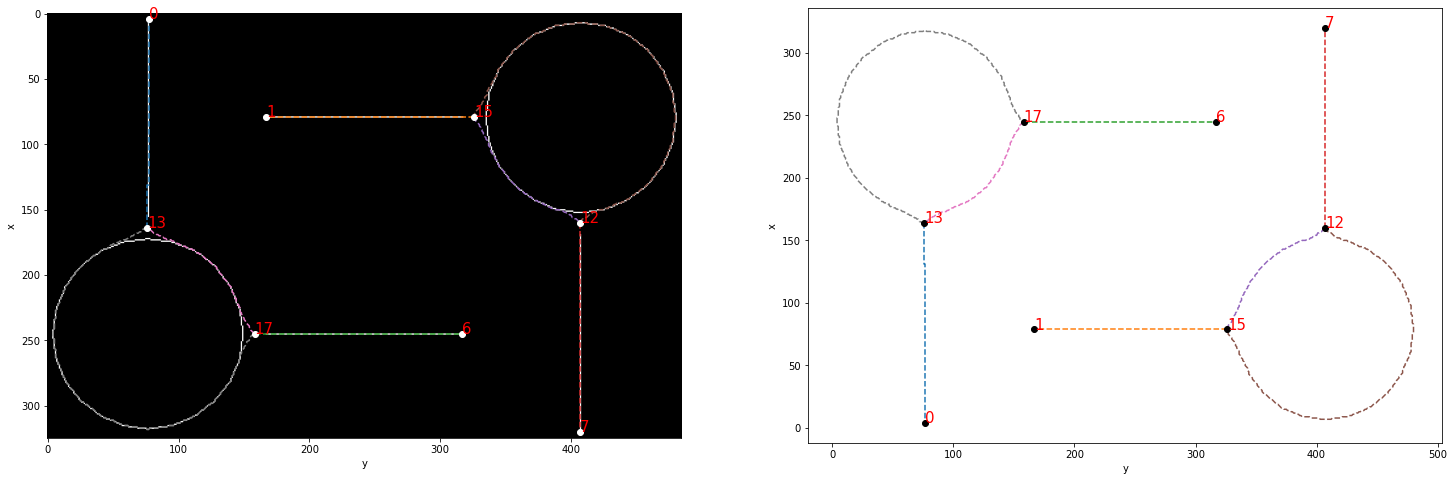

In [523]:
# PICK A TRIAL FOR subsequent p[lots
indtrial = 137
dset_rule = "linetocircle"

# MBH.plot_overview_trial(dset, indtrial, True, "alignment_diff_chunks")
MBH.plot_overview_trial(dset_rule, indtrial,True, alignment_col="alignment_diff_chunks")

##### Other

In [132]:
# For each datset, sort trials by most to least aligned.
# Use concatenated dataset
D, DatWide, DatFlat, DatThisAgg, DatFlatAgg = MBH.extract_concatenated_aggregated_dataset()



Done!, new len of dataset 569
Monkey priors (datasets):  ['circletoline', 'linetocircle', 'lolli']
Model scores (colnames):  ['behmodpost_circletoline_chunks', 'behmodpost_linetocircle_chunks', 'behmodpost_lolli_chunks']
{'behmodpost_lolli_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_linetocircle_chunks': [<function <lambda> at 0x7efe3b0d1440>], 'behmodpost_circletoline_chunks': [<function <lambda> at 0x7efe3b0d1440>]}
{'behmodpost_lolli_chunks': ['mean'], 'behmodpost_linetocircle_chunks': ['mean'], 'behmodpost_circletoline_chunks': ['mean']}
{'score': ['mean']}


In [20]:
# Given a single task, plot parses across all models and rules
sortby = "prior"
plot_beh_task = True
for mclass in list_mclass:
    print("dataset:", dset)
    print("mclass:", mclass)

    H = MBH.DictTestDH[(dset, mclass)]["H"]
    D = MBH.DictTestDH[(dset, mclass)]["D"]

    for mrule in MBH.ColNames.Rules:
        tit = f"{dset}-{mclass}-{mrule}"
#             MBH.DictTestDH[(dset, mclass)]["H"].plot_prior_likeli_sorted(mrule, indtrial, sortby, title=tit);
        H.plot_parses_ordered(indtrial, mrule, plot_beh_task=plot_beh_task, plots=["prior"], title=f"{mclass}-{mrule}")
        plot_beh_task = False

dataset: circletoline
mclass: chunks


KeyError: ('circletoline', 'chunks')

In [ ]:
## plots of scores (priors and likelis)

from pythonlib.tools.plottools import saveMultToPDF
# Given a single task, plot scores across all models and rules
# Given a single task, plot parses across all models and rules
sortby = "prior"
plot_beh_task = True
list_fig = []
for mclass in list_mclass:
    print("dataset:", dset)
    print("mclass:", mclass)

    H = MBH.DictTestDH[(dset, mclass)]["H"]
    D = MBH.DictTestDH[(dset, mclass)]["D"]

    for mrule in MBH.ColNames.Rules:
        tit = f"{dset}-{mclass}-{mrule}"
        fig = MBH.DictTestDH[(dset, mclass)]["H"].plot_prior_likeli_sorted(mrule, indtrial, sortby, title=tit);
        list_fig.append(fig)
        
saveMultToPDF("/tmp/tmp.pdf", list_fig)

# indtrial = 125
# sortby = "prior"
# for dset in list_dset:
#     for mclass in list_mclass:
#         print("dataset:", dset)
#         print("mclass:", mclass)

#         H = MBH.DictTestDH[(dset, mclass)]["H"]
#         D = MBH.DictTestDH[(dset, mclass)]["D"]

#         coldiff = MBH.ColNames.colnames_minus_usingnames(mclass)
#         print(coldiff)

#         for mrule in MBH.ColNames.Rules:
#             tit = f"{dset}-{mclass}-{mrule}"
#             MBH.DictTestDH[(dset, mclass)]["H"].plot_prior_likeli_sorted(mrule, indtrial, sortby, title=tit);



#### OLDER PLOTS (could still be good)

##### Focus on a single model, deeper analsysi

In [ ]:
dset = "Red_lines5_straight"
indtrial = 49
mclass = "mix_features_nd"
mrule = "straight"

DH = MBH.DictTestDH[(dset, mclass)]
D = DH["D"]
H = DH["H"]

H.print_overview_params()

In [ ]:
# Extract FeatureExtractor features for each trial
PriorProbsCheck = H.compute_store_priorprobs_vectorized(just_sanity_check=True)


In [ ]:
print(np.exp(PriorProbsCheck["straight"][indtrial]))
print(H.PriorProbs["straight"][indtrial])

In [ ]:
H.plot_overview_trial("straight", indtrial)

##### Other summary plots

In [ ]:
### plot summary for each dset - mclass - model
sortby = "prior"
for dset in list_dset:
    for mclass in list_mclass:

        H = MBH.DictTestDH[(dset, mclass)]["H"]
        D = MBH.DictTestDH[(dset, mclass)]["D"]

        for mrule in MBH.ColNames.Rules:
            tit = f"{dset}-{mclass}-{mrule}"
            print(tit)
            
            MBH.DictTestDH[(dset, mclass)]["H"].plot_overview_results(mrule)



In [ ]:
# 1) Same task, all model classes.
list_task = MBH.Dtest_SameDset.Dat["character"].unique().tolist()
import random
task = random.sample(list_task, 1)[0]

for mclass in MBH.ListMclass:
    for mrule in MBH.ListMrule[mclass]:
#         mrule = "straight"
        MBH.DictTestH_SameDset[mclass].plot_parses_ordered(1, mrule)

In [ ]:
# Evaluate, the trainimng tasks
for H in MBH.DictTrainedH.values():
    H.compute_all()
    
    

In [ ]:
MBH.DictTrainedH[('mix_features_dt', 'bent')].plot_overview_trial("bent", 1)
# MBH.DictTrainedH[('mix_features_dt', 'bent')].compute_all(mode="test")

In [ ]:
# Plot graph

mrule = "bent"
H = MBH.DictTrainedH[('mix_features_dt', 'bent')]

H.plot_parses_trial(1)

In [ ]:
list_parser = D.parser_list_of_parsers(1, parser_names=["parser_graphmod"])
for parser in list_parser:
    parser.plot_graph()

In [ ]:
indtrial = 1
D = H.D
# list_parser = D.parser_list_of_parsers(indtrial, parser_names=["parser_graphmod"])
list_parser = D.parser_list_of_parsers(indtrial)
for parser in list_parser:
    parser.plot_graph()

In [ ]:
H.plot_parses_ordered(indtrial);

#### DEVELOP MORE MODELS HERE

In [ ]:
# GROUPING_LEVELS = rule_list
# # model_class = "mkvsmk"
# for model_class in ["mkvsmk", "lines5"]:
#     for D, rule in zip(Dlist, rule_list):
#         # Get Dataset
#         Dlist_this = [DictD[(rule, "train")]]
#         GROUPING_LEVELS_this = [rule]
#         ListBMH, list_dsets, ListH= cross_dataset_model_wrapper_params(Dlist_this, model_class, GROUPING_LEVELS_this)

#         # Optimize
#         if model_class=="lines5":
#             bmh_optimize_single(ListBMH, D.identifier_string(),  rule)
#         elif model_class=="mkvsmk":
#             for H in ListH:
#                 H.compute_store_priorprobs_vectorized()
#                 H.compute_store_likelis()
#                 H.compute_store_likelis_logprobs()
#                 H.compute_store_posteriors()

#         ### Save
#         bmh_save(SDIR, Dlist_this, model_class, GROUPING_LEVELS_this, ListH, "train")

#         bmh_results_to_dataset(ListBMH, suffix=model_class)

#### DIRECTION BIAS

In [ ]:
GROUPING_LEVELS = rule_list
# model_class = "mkvsmk"
# model_class = "bd"
# model_class = "mix_features_dbn"
model_class = "mix_features_t"
import random
Dthis = Dlist[0]
inds = random.sample(range(len(Dthis.Dat)), 50)
Dthis = Dthis.copy().subsetDataset(inds)
rule = "bent"

Dlist_this = [Dthis]
GROUPING_LEVELS_this = [rule]
ListBMH, list_dsets, ListH= cross_dataset_model_wrapper_params(Dlist_this, model_class, GROUPING_LEVELS_this)

In [ ]:
H = ListH[0]
# H.compute_all(mode="test")

In [ ]:
print(H.params_prior(H.ListModelsIDs[0]))
ListBMH[0]

In [ ]:
# Grid search

### PLOT COST LANDSCAPE
# from math import pi
# array_theta_angle = np.linspace(-5, -5, 1)
# array_transform_angle = np.linspace(0, 5, 1)

params_grid = [
    np.linspace(-2, 2, 10),
#     np.linspace(-3, 6, 10),
#     np.linspace(0, 5, 5), 
#     np.linspace(3,3, 1), 
    np.linspace(2,2,1)]

from pythonlib.behmodel.behmodel_handler import bmh_score_grid
out = bmh_score_grid(ListBMH, "Red_lines5_straight", "bent", params_grid)



In [ ]:
# Plot grid search

# expand out
list_prms = []
for o in out:
    for i, p in enumerate(o["prms"]):
        o[f"p{i}"] = p
        list_prms.append(f"p{i}")
list_prms = list(set(list_prms))

import pandas as pd
import seaborn as sns
from pythonlib.tools.snstools import rotateLabel

df = pd.DataFrame(out)
for p in list_prms:
    fig = sns.catplot(data=df, x=p, y="cost")
    rotateLabel(fig)
    



In [ ]:
# Plot grid search

# expand out
list_prms = []
for o in out:
    for i, p in enumerate(o["prms"]):
        o[f"p{i}"] = p
        list_prms.append(f"p{i}")
list_prms = list(set(list_prms))

import pandas as pd
import seaborn as sns
from pythonlib.tools.snstools import rotateLabel

df = pd.DataFrame(out)
for p in list_prms:
    fig = sns.catplot(data=df, x=p, y="cost")
    rotateLabel(fig)
    



In [ ]:
# Optimize
    
if model_class in ["lines5", "bdn"]:
    if model_class == "bdn":
        bounds = [
            (-20, 20),
            (0., 10),
            (0., 10),
            (0., 10),
            (0., 10),
            (0., 10)]
    else:
        bound = None
    res = bmh_optimize_single(ListBMH, ListBMH[0]["id_dset"],  ListBMH[0]["id_mod"], bounds=bounds)
elif model_class=="mkvsmk":
    for H in ListH:
        H.compute_store_priorprobs_vectorized()
        H.compute_store_likelis()
        H.compute_store_likelis_logprobs()
        H.compute_store_posteriors()

In [ ]:
H = ListBMH[0]["H"]
H.params_prior("bent")

In [ ]:
params_input = {}
params_input["features"]= {
    "circ": [0, None],
    "angle_travel": [0., tuple([0.])],
    "nstrokes": [0., tuple([3.])]
}


F = params_input["features"]
params_mc = {}
params_mc["thetas"] = {feat: prms[0] for feat, prms in F.items()}
params_mc["transformations"] = {feat: prms[1] for feat, prms in F.items() if prms[1] is not None}
params_fe = {
    "features":list(F.keys())
}


In [ ]:
H.plot_overview_results("bent");

In [ ]:
get_single_model("mix_features_bdn")

In [ ]:

H = ListBMH[0]["H"]
H.params_prior(rule)

In [ ]:
H.plot_overview_trial(rule, 2)

In [ ]:
### Save
bmh_save(SDIR, Dlist_this, model_class, GROUPING_LEVELS_this, ListH, "train")

bmh_results_to_dataset(ListBMH, suffix=model_class)

### Notes, taken from devo_taskmodel_071121

In [ ]:
# # ## OUTLINE


# Tasks module (holds information for this task)

# Behavior module (holds behavior on this task)

# Parses module
# - holds all parses for a given task.
# - Representations:
#     - strokes
#     - symbolic features (number strokes)
#     - graph control pts.
#     - [optional: consider direction?]

# Model module
# - Flexible holding of params, can train given new set of tasks, if needed.
#     - Prior scorer
#     - Likeli scorer
#     - Posterior scorer
# - can score any input parses, P(parse | prior)
#     - Parses represented both as strokes and graph control pts (and objects ?)
#     - INPUT: All kinds of models
#         - ActionGrammar (log linear version)
#             - MotorCost
#             - [Flatten out MotorCost so that Action Grammar is flat]
#             - [Each of these combined in log linear model]
#         - Stroke manifold model (or other form of learned action primitive)
#         - GNS
# - can score any behavior, P(beh|parse)
#     - INPUT: scoring functions (likeli)
#         - 
# - can get summary score (posterior)
#     - INPUT: flexible posterior function
        
        



# # Structure of current taskmodel

# Model
#     - parser
#     - prior fun
#     - prior norm
#     - likelis
#     - posterior

# Dataset
# - data
# - Model
# - plots/summaries

# getprior
# getlikeli




#### Scratch

In [ ]:
def score_function(parses, ver="ink", normalization = "inverse", test=False,
                  use_torch=False, origin=None):
    """ 
    - ver, str, determines what score to use
    --- "ink", then total distnace traveled on page
    --- "travel", then total distance traveled, including
    gaps, starting from position of first touch.
    - normalization, how to normalize raw distnace. distance will
    be that more positive is more worse. 
    --- inverse take inverse, so that now less positive is worse.
    --- negative, ...
    """
    from pythonlib.drawmodel.features import strokeDistances, computeDistTraveled

    if test:
        # then just return random number, one for each parse
        return torch.tensor([random.random() for _ in range(len(parses))])    
    
    if ver=="ink":
        # === Total ink used
        distances = [np.sum(strokeDistances(strokes)) for strokes in parses]
    elif ver=="travel":
        # conisder origin to be onset of first storke.
        # Note: has issue in that a single stroke task, flipped, is idnetical cost to the same task unflipped.
        # leads to problems later since unique(score) is used to throw out redundant parses.
        distances_traveled = [computeDistTraveled(strokes, origin=strokes[0][0,[0,1]]) for strokes in parses]
        distances = distances_traveled
    elif ver=="travel_from_orig":
        # pass in origin. 
        assert origin is not None, " must pass in coordinate for origin"
        distances_traveled = [computeDistTraveled(strokes, origin=origin) for strokes in parses]
        distances = distances_traveled

    elif ver=="nstrokes":
        # num strokes
        # == plit histogram of num strokes
        nstrokes = [len(p) for p in parses]        
    else:
        print(ver)
        assert False, "not codede"
        
    if use_torch:
        distances = torch.tensor(distances)
    else:
        distances = np.array(distances)
        
    if normalization=="inverse":
        return 1/distances
    elif normalization=="negative":
        return -distances
    else:
        print(normalization)
        assert False, "not coded"

## GENERATIVE MODEL (like bpl)

In [ ]:
from pythonlib.behmodel.drawmodel.model.model import CharacterModel as DrawModel
from pythonlib.behmodel.drawmodel.library.library import Library
from pythonlib.bpl.strokesToProgram import plotMP

lib = Library()
DM = DrawModel(lib)
ctype = DM.sample_type()
plotMP(ctype)

In [ ]:
## INFERENCE

# 1) For each parsed stroke, assign to max likeli using mixture model.
# OR:
# 1) assign a prob based on mixture model (posterior score)

# 2) Fit model using similar method to Lake

